In [1]:
import networkx as nx
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import time

import torch
import scipy.sparse
from torch import Tensor
from torch.utils.dlpack import to_dlpack, from_dlpack

import torch_geometric.data
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx, to_networkx
from torch_geometric.utils import k_hop_subgraph
from torch_geometric.utils import is_undirected, to_undirected

from pgmpy.estimators.CITests import chi_square
from scipy.special import softmax



In [2]:
G1 = nx.Graph()
G1.add_nodes_from([1, 2, 3])
G1.add_edges_from([(1, 2), (1, 3), (2, 3)])
print(G1)

Graph with 3 nodes and 3 edges


In [3]:
list(G1.edges)

[(1, 2), (1, 3), (2, 3)]

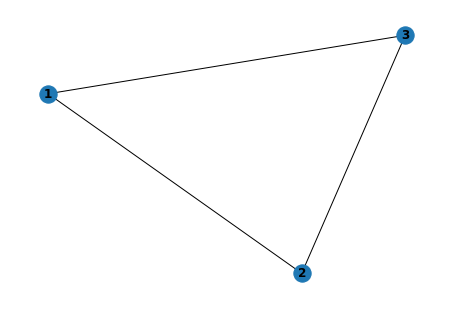

In [4]:
nx.draw(G1, with_labels=True, font_weight='bold')

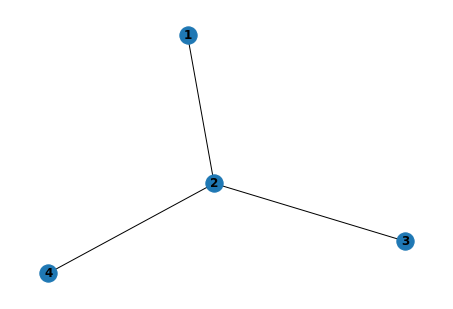

In [5]:
G2 = nx.Graph()
G2.add_nodes_from([1, 2, 3, 4])
G2.add_edges_from([(1, 2), (2, 3), (2, 4)])
nx.draw(G2, with_labels=True, font_weight='bold')

In [7]:
g_int = nx.intersection(G1, G2)

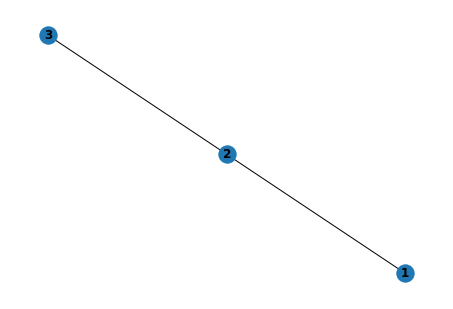

In [8]:
g_int.remove_nodes_from(list(nx.isolates(g_int)))
nx.draw(g_int, with_labels=True, font_weight='bold')


In [9]:
n_tp = g_int.number_of_edges()
n_tp

2

In [10]:
n_fp = len(G1.edges() - g_int.edges())
n_fp

1

In [11]:
n_fn = len(G2.edges() - g_int.edges())
n_fn

1

In [12]:
G2.edges() - g_int.edges()

{(2, 4)}

In [13]:
precision = n_tp / (n_tp + n_fp)
recall = n_tp / (n_tp + n_fn)
f1_score = 2*(precision * recall)/(precision + recall)
f1_score

0.6666666666666666

In [14]:
nx.graph_edit_distance(G1, G2)

3.0

In [3]:
def ba(n, m, role_start=0):
    G = nx.barabasi_albert_graph(n, m)
    labels = [role_start for i in range(n)]
    return G, labels


def house(start, role_start=1):
    """Builds a house-like  graph, with index of nodes starting at start
    and role_ids at role_start
    INPUT:
    -------------
    start       :    starting index for the shape
    role_start  :    starting index for the roles
    OUTPUT:
    -------------
    graph       :    a house shape graph, with ids beginning at start
    roles       :    list of the roles of the nodes (indexed starting at
                     role_start)
    """
    graph = nx.Graph()
    graph.add_nodes_from(range(start, start + 5))
    graph.add_edges_from(
        [
            (start, start + 1),
            (start + 1, start + 2),
            (start + 2, start + 3),
            (start + 3, start),
        ]
    )
    graph.add_edges_from([(start + 4, start), (start + 4, start + 1)])
    roles = [role_start, role_start, role_start + 1, role_start + 1, role_start + 2]
    return graph, roles


def build_ba_shapes(n_basis, n_shapes, rdm_basis_plugins=True, rdm_shape_plugins=True, pos=3, add_random_edges=0, m=5):
    # where you will plugin the houses
    # Sample (with replacement) where to attach the new motifs
    if rdm_basis_plugins is True:
        plugins = np.random.choice(n_basis, n_shapes, replace=False)
    else:
        spacing = math.floor(n_basis / n_shapes)
        plugins = [int(k * spacing) for k in range(n_shapes)]

    basis, role_id = ba(n_basis, m)
    start = n_basis
    for shape_id in range(n_shapes):
        graph_s, role_graph_s = house(start)
        n_s = nx.number_of_nodes(graph_s)
        basis.add_nodes_from(graph_s.nodes())
        basis.add_edges_from(graph_s.edges())
        if rdm_shape_plugins is True:
            pos = np.random.choice(range(start, start+n_s))
        basis.add_edges_from([(pos, plugins[shape_id])])
        role_id += role_graph_s
        start += n_s

    if add_random_edges > 0:
        # add random edges between nodes:
        n_rand = int(n_basis*add_random_edges)
        for p in range(n_rand):
            src, dest = np.random.choice(nx.number_of_nodes(basis), 2, replace=False)
            basis.add_edges_from([(src, dest)])
            
            
    # Add constant node features
    feat_dict = {i:{'feat': np.array([1], dtype=np.float32)} for i in basis.nodes()}
    nx.set_node_attributes(basis, feat_dict)
    
    # Convert graph into undirected graph
    basis = basis.to_undirected()

    return basis, role_id, plugins


In [4]:
n_basis, n_shapes = 2000, 200

G, labels, plugins = build_ba_shapes(n_basis, n_shapes)
#nx.draw(G, cmap=plt.get_cmap('viridis'), node_color=labels, with_labels=True, font_weight='bold')

In [5]:
plugins

array([1665, 1827, 1299, 1662, 1225,   52,  951,  838, 1220,    4, 1402,
       1038, 1381,   30, 1102,  391, 1053, 1879, 1122,  178, 1997,  389,
        865, 1274, 1470,  886, 1483, 1523,  543, 1741, 1611, 1555, 1790,
        772,  306, 1063, 1967, 1199,  592, 1525, 1641,  578, 1369,  985,
        452,  655,  805, 1052, 1889,  550,  577,  100, 1018, 1562, 1700,
       1770, 1736,  925,  334, 1798, 1498,  230, 1090, 1342, 1530, 1791,
       1612, 1855,  553,  750, 1565,  776, 1540,  139, 1861,  980, 1041,
        420,  162, 1468, 1637, 1743,  166, 1230,  957, 1264, 1663, 1892,
        509, 1514, 1432, 1472, 1754, 1307,  240, 1250, 1349, 1882,  257,
       1973,  852,  305,  261, 1623, 1017, 1931,  968,  946, 1704, 1633,
       1258,  515, 1891, 1966,  704, 1899, 1080,  441, 1331,  544,  504,
        707, 1974, 1348,  283,  883,  684,  267, 1678,  674, 1031,  295,
        141, 1212, 1345, 1702,  571,  153,  806,   10, 1610,  795,  868,
       1011,  952,  327, 1574,  127,  622,  431,  8

In [6]:
def preprocess_input_graph(G, labels, normalize_adj=False):
    """ Load an existing graph to be converted for the experiments.
    Args:
        G: Networkx graph to be loaded.
        labels: Associated node labels.
        normalize_adj: Should the method return a normalized adjacency matrix.
    Returns:
        A dictionary containing adjacency, node features and labels
    """
    adj = np.array(nx.to_numpy_matrix(G))
    if normalize_adj:
        sqrt_deg = np.diag(1.0 / np.sqrt(np.sum(adj, axis=0, dtype=float).squeeze()))
        adj = np.matmul(np.matmul(sqrt_deg, adj), sqrt_deg)

    existing_node = list(G.nodes)[-1]
    feat_dim = G.nodes[existing_node]["feat"].shape[0]
    f = np.zeros((G.number_of_nodes(), feat_dim), dtype=float)
    for i, u in enumerate(G.nodes()):
        f[i, :] = G.nodes[u]["feat"]

    # add batch dim
    #adj = np.expand_dims(adj, axis=0)
    #f = np.expand_dims(f, axis=0)
    #labels = np.expand_dims(labels, axis=0)
    return {"adj": adj, "feat": f, "labels": labels}

In [7]:
data = from_networkx(G, all)
data.edge_index.shape

/Users/kenzaamara/.conda/envs/Explain/lib/python3.8/site-packages/torch_geometric/utils/convert.py:164: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  data[key] = torch.tensor(value)


torch.Size([2, 22750])

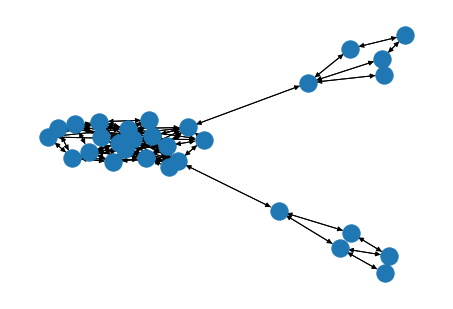

In [12]:
g = torch_geometric.utils.to_networkx(data, to_undirected=False)
nx.draw(g)

In [8]:
data.num_node_features
data.num_classes = len(np.unique(labels))
data.y = torch.LongTensor(labels)

In [9]:
n = data.num_nodes
data.train_mask, data.val_mask, data.test_mask = torch.zeros(n, dtype=torch.uint8), torch.zeros(n, dtype=torch.uint8), torch.zeros(n, dtype=torch.uint8)

In [10]:
from sklearn.model_selection import train_test_split

train_ids, test_ids = train_test_split(range(n), test_size=0.2, random_state=42, shuffle=True)
train_ids, val_ids = train_test_split(train_ids, test_size=0.15, random_state=42, shuffle=True)

data.train_mask[train_ids] = 1
data.val_mask[val_ids] = 1
data.test_mask[test_ids] = 1

In [11]:
len(data.y[data.val_mask])

/var/folders/5m/qnq98p591m30tpzhzz2j3nwr0000gn/T/ipykernel_18451/2781205052.py:1: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/IndexingUtils.h:30.)
  len(data.y[data.val_mask])


360

In [12]:
nodes_sub, edge_index_sub, new_node_idx, edge_mask = k_hop_subgraph(32, 2, data.edge_index, relabel_nodes=True)
# nodes_sub is subset
# relabel_nodes changes edge_index indexation

In [13]:
new_node_idx

tensor([29])

In [41]:
mapping = {int(v): k for k, v in enumerate(subset)}
mapping

{1: 0, 30: 1, 31: 2, 32: 3, 33: 4, 34: 5}

In [40]:
nodes_sub

tensor([ 1, 30, 31, 32, 33, 34])

In [30]:
data.x[nodes_sub]

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]])

In [26]:
#relabel_nodes is False
edge_index_sub

tensor([[ 1, 30, 30, 30, 31, 31, 31, 31, 32, 32, 33, 33, 34, 34],
        [31, 31, 33, 34,  1, 30, 32, 34, 31, 33, 30, 32, 30, 31]])

In [31]:
#relabel_nodes is True
edge_index_sub

tensor([[0, 1, 1, 1, 2, 2, 2, 2, 3, 3, 4, 4, 5, 5],
        [2, 2, 4, 5, 0, 1, 3, 5, 2, 4, 1, 3, 1, 2]])

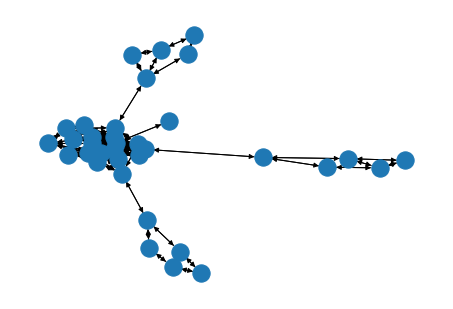

In [32]:
graph = to_networkx(data)
nx.draw(graph)

[32, 1, 33, 34, 30, 31]
[(32, 31), (32, 33), (1, 31), (33, 30), (33, 32), (34, 30), (34, 31), (30, 31), (30, 33), (30, 34), (31, 1), (31, 30), (31, 32), (31, 34)]


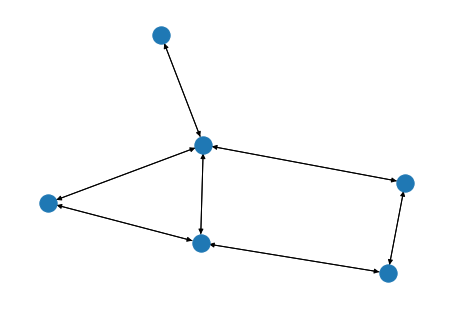

In [37]:
subset = nodes_sub
subgraph = graph.subgraph(subset.tolist())
nx.draw(subgraph)
print(subgraph.nodes())
print(subgraph.edges())

[0, 1, 2, 3, 4, 5]
[(0, 2), (1, 2), (1, 4), (1, 5), (2, 0), (2, 1), (2, 3), (2, 5), (3, 2), (3, 4), (4, 1), (4, 3), (5, 1), (5, 2)]


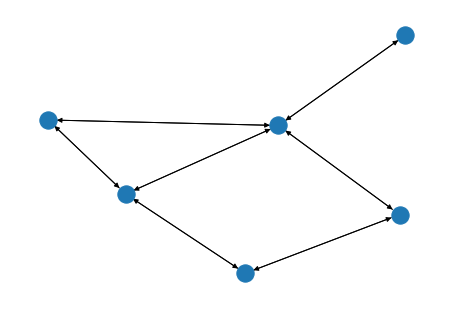

In [39]:
data_sub = Data(x=nodes_sub, edge_index=edge_index_sub)
subgraph = to_networkx(data_sub)
nx.draw(subgraph)
print(subgraph.nodes())
print(subgraph.edges())

In [60]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.num_layers = 2
        self.conv1 = GCNConv(data.num_node_features, 16)
        self.conv2 = GCNConv(16, data.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        
        return F.log_softmax(x, dim=1)

In [62]:
class GCN(torch.nn.Module):
    def __init__(self, num_node_features, num_classes, num_layers, num_hidden):
        super().__init__()
        self.num_node_features, self.num_classes, self.num_layers, self.num_hidden = num_node_features, num_classes, num_layers, num_hidden
        self.layers = []
        self.layers.append(GCNConv(self.num_node_features, self.num_hidden))
        for j in range(self.num_layers-2):
            self.layers.append(GCNConv(self.num_hidden, self.num_hidden))
        self.layers.append(GCNConv(self.num_hidden, self.num_classes))

    def forward(self, x, edge_index):
        for j in range(self.num_layers-1):
            print(self.layers[j])
            x = self.layers[j](x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, training=self.training)
        print(self.layers[j])
        x = self.layers[-1](x, edge_index)
        
        

In [63]:
from torch.optim.lr_scheduler import ReduceLROnPlateau, ExponentialLR, StepLR

n_epochs = 200

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(data.num_node_features, data.num_classes, 3, 16).to(device)
data = data.to(device)


optimizer = torch.optim.Adam(model.parameters(), lr=0.1, weight_decay=5e-4)
#scheduler = ReduceLROnPlateau(optimizer, 'min')
#scheduler = ExponentialLR(optimizer, gamma=0.99)
scheduler = StepLR(optimizer, step_size=100, gamma=0.99)

val_err = []
train_err = []
        

model.train()
for epoch in range(n_epochs):
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    val_loss = F.nll_loss(out[data.val_mask], data.y[data.val_mask])
    
    if epoch%10==0:
        val_err.append(val_loss.item())
        train_err.append(loss.item())
        
        
    loss.backward()
    optimizer.step()
    scheduler.step()
    #scheduler.step(val_loss)

ValueError: optimizer got an empty parameter list

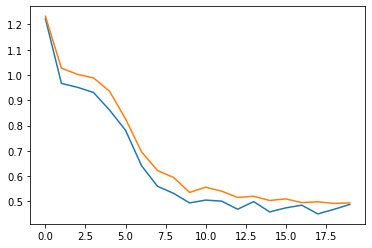

In [15]:
plt.plot(range(n_epochs//10), val_err)
plt.plot(range(n_epochs//10), train_err)

In [16]:
model.eval()
pred = model(data.x, data.edge_index).argmax(dim=1)
correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
acc = int(correct) / int(data.test_mask.sum())
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.9317


/var/folders/5m/qnq98p591m30tpzhzz2j3nwr0000gn/T/ipykernel_18451/1796556738.py:3: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/IndexingUtils.h:30.)
  correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()


In [17]:
pred = model(data.x, data.edge_index).argmax(dim=1)
correct = (pred[data.train_mask] == data.y[data.train_mask]).sum()
acc = int(correct) / int(data.train_mask.sum())
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.9098


/var/folders/5m/qnq98p591m30tpzhzz2j3nwr0000gn/T/ipykernel_18451/3035444030.py:2: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/IndexingUtils.h:30.)
  correct = (pred[data.train_mask] == data.y[data.train_mask]).sum()


In [56]:
edge_mask[indices] = torch.FloatTensor([1]*num_top_edges)
explainer.visualize_subgraph(node_idx, data.edge_index, edge_mask, y = data.y, threshold=0.99)

NameError: name 'num_top_edges' is not defined

In [18]:
def get_explanation(data, edge_mask, num_top_edges = 6, is_hard_mask = False):
    #values,indices = edge_mask.topk(num_top_edges)
    if is_hard_mask:
        explanation = data.edge_index[:,np.where(edge_mask==1)[0]]
    else:
        indices = (-edge_mask).argsort()[:num_top_edges]
        explanation = data.edge_index[:,indices]

    G_expl = nx.Graph()
    G_expl.add_nodes_from(np.unique(explanation))

    for i, (u, v) in enumerate(explanation.t().tolist()):
        G_expl.add_edge(u, v)
        
    return(G_expl)

In [19]:
def get_ground_truth_ba_shapes(node):
    base = [0, 1, 2, 3, 4]
    ground_truth = []
    offset = node % 5
    ground_truth = [node - offset + val for val in base]
    start = ground_truth[0]
    graph, role = house(start, role_start=1)
    return graph, role

In [20]:
def scores(G1, G2):
    g_int = nx.intersection(G1, G2)
    g_int.remove_nodes_from(list(nx.isolates(g_int)))

    n_tp = g_int.number_of_edges()
    n_fp = len(G1.edges() - g_int.edges())
    n_fn = len(G2.edges() - g_int.edges())

    precision = n_tp / (n_tp + n_fp)
    recall = n_tp / (n_tp + n_fn)
    if n_tp == 0:
        f1_score = 0
    else: 
        f1_score = 2 * (precision * recall) / (precision + recall)

    ged = nx.graph_edit_distance(G1, G2)

    return recall, precision, f1_score, ged

In [21]:
def evaluate(node_idx, data, edge_mask, num_top_edges):
    G_true, role = get_ground_truth_ba_shapes(node_idx)
    # nx.draw(G_true, cmap=plt.get_cmap('viridis'), node_color=role, with_labels=True, font_weight='bold')
    G_expl = get_explanation(data, edge_mask, num_top_edges)
    plt.figure()
    nx.draw(G_expl,  with_labels=True, font_weight='bold')
    plt.show()
    plt.clf()
    return scores(G_expl, G_true)


Explain node 2000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 404.63it/s]


[0.9190733  0.22387436 0.15962179 0.22777154 0.25508648 0.21722127
 0.1990977  0.22491577 0.82102954 0.15872812 0.23777185 0.8392773
 0.19098997 0.86580026]


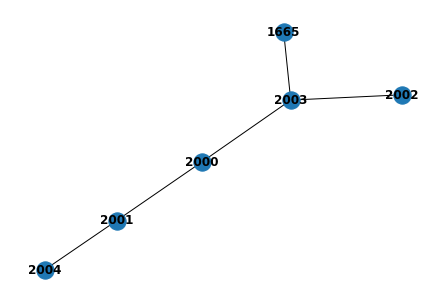

f1_score, ged 0.7272727272727272 4.0



Explain node 2001: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 466.90it/s]

[0.8265312  0.8165981  0.76868254 0.77264285 0.8793275  0.09157026
 0.8485478  0.18012127 0.8209327  0.81944466 0.14140272 0.87774646]


<Figure size 432x288 with 0 Axes>

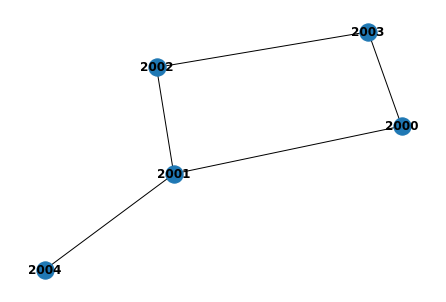

f1_score, ged 0.9090909090909091 1.0



Explain node 2002: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 393.32it/s]

[0.22985294 0.19053    0.8442345  0.88584876 0.8163918  0.36325198
 0.20691039 0.8330008  0.8390642  0.85137653 0.17031024 0.20317915
 0.82600176 0.18488875]


<Figure size 432x288 with 0 Axes>

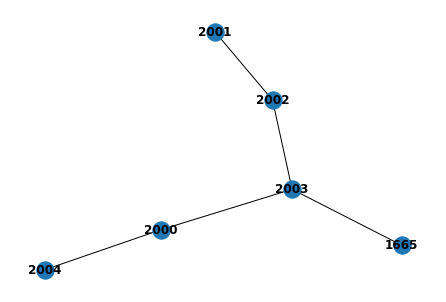

f1_score, ged 0.7272727272727272 4.0



Explain node 2003: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 470.88it/s]

[0.8460269  0.9158822  0.835577   0.2331419  0.22801633 0.08003879
 0.8557353  0.20634653 0.8131481  0.834206   0.23016438 0.8217876
 0.18014525 0.18887998 0.8519081  0.23844114 0.20455001 0.22438836
 0.25048897 0.21297036 0.18481581 0.24983527 0.23353757 0.8289273 ]


<Figure size 432x288 with 0 Axes>

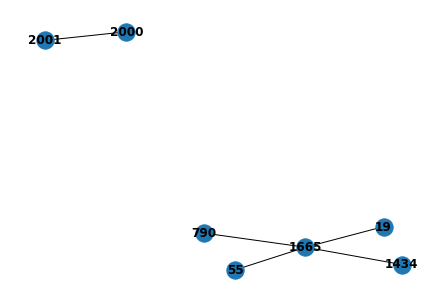

f1_score, ged 0.1818181818181818 7.0



Explain node 2004: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 515.77it/s]


[0.8085748  0.21344852 0.7658273  0.8261357  0.2125014  0.73578346
 0.14245814 0.19833483 0.13816427 0.8676365  0.8094148  0.20102157]


<Figure size 432x288 with 0 Axes>

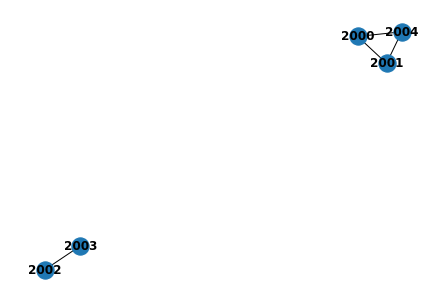

f1_score, ged 0.8 2.0



Explain node 2005: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 505.58it/s]


[0.8736717  0.19511138 0.23193435 0.8242139  0.3055969  0.8969541
 0.88255894 0.83566904 0.832698   0.19525163 0.20576079 0.83059585
 0.35631758 0.22657305]


<Figure size 432x288 with 0 Axes>

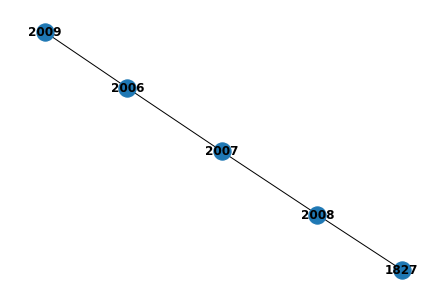

f1_score, ged 0.6 2.0



Explain node 2006: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 422.26it/s]

[0.82395035 0.8312519  0.11394876 0.14530046 0.7899034  0.7938699
 0.60433704 0.9264384  0.15327215 0.12795614 0.76873255 0.8830621 ]


<Figure size 432x288 with 0 Axes>

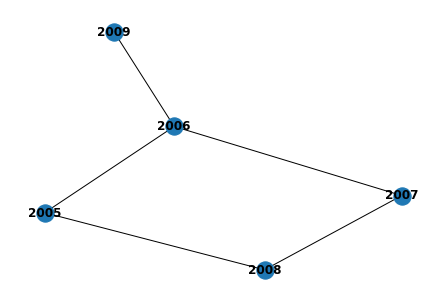

f1_score, ged 0.9090909090909091 1.0



Explain node 2007: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 365.66it/s]

[0.8165146  0.14933142 0.8658692  0.1408984  0.18171218 0.2857437
 0.1413292  0.81616336 0.22189201 0.07917061 0.87509304 0.15474196
 0.1927456  0.19451544]


<Figure size 432x288 with 0 Axes>

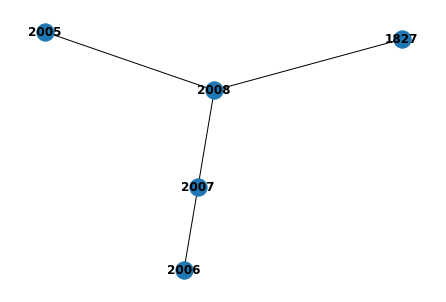

f1_score, ged 0.6 2.0



Explain node 2008: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 456.70it/s]

[0.24356388 0.25435647 0.2307983  0.84388393 0.23816241 0.822861
 0.80937403 0.88483477 0.17487748 0.19276313 0.30799186 0.8653566
 0.3306781  0.18978812 0.24102026 0.25230044 0.8191698  0.17283505
 0.26998478 0.23053013 0.20663123 0.8642807  0.25202888 0.819416  ]


<Figure size 432x288 with 0 Axes>

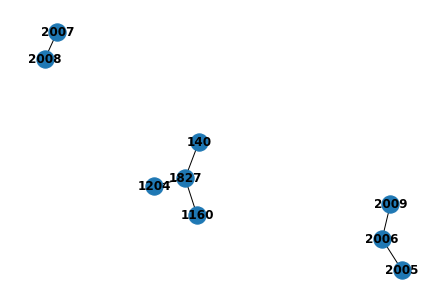

f1_score, ged 0.5 10.0



Explain node 2009: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 473.33it/s]

[0.8004724  0.87528735 0.10549399 0.83195424 0.19770995 0.12414408
 0.79472953 0.13263571 0.82662773 0.8683647  0.83778673 0.8081178 ]


<Figure size 432x288 with 0 Axes>

KeyboardInterrupt: 

In [23]:
from torch_geometric.nn import GNNExplainer

list_node_idx = range(n_basis,n_basis+5*n_shapes)
F1_scores = []
GED = []
Recall = []
Precision = []

explainer = GNNExplainer(model)
for node_idx in list_node_idx:
    node_feat_mask, edge_mask = explainer.explain_node(node_idx, x = data.x, edge_index = data.edge_index)
    node_feat_mask, edge_mask = node_feat_mask.detach().numpy(), edge_mask.detach().numpy()
    print(edge_mask[np.where(edge_mask>0)[0]])
    recall, precision, f1_score, ged = evaluate(node_idx, data, edge_mask, num_top_edges = 6)
    Recall.append(recall)
    Precision.append(precision)
    F1_scores.append(f1_score)
    GED.append(ged)
    print("f1_score, ged", f1_score, ged)

In [63]:
print(np.mean(F1_scores), np.mean(GED), np.mean(Recall), np.mean(Precision))

0.7026123301985372 3.413793103448276 0.6264367816091956 0.810919540229885


In [24]:
from captum._utils.common import (
    _format_additional_forward_args,
    _format_input,
    _format_output,
)
from captum._utils.gradient import (
    apply_gradient_requirements,
    compute_layer_gradients_and_eval,
    undo_gradient_requirements,
)
from captum._utils.typing import TargetType
from captum.attr import Saliency, IntegratedGradients, LayerGradCam

In [25]:
def mask_to_directed(edge_mask, edge_index):
    directed_edge_mask = edge_mask.copy()
    for i, (u, v) in enumerate(edge_index.t().tolist()):
        if u > v:
            directed_edge_mask[i]=0
    return directed_edge_mask

In [26]:
def model_forward(edge_mask, model, node_idx, x, edge_index):
    out = model(x, edge_index, edge_mask)
    return out[[node_idx]]

def model_forward_node(x, model, edge_index, node_idx):
    out = model(x, edge_index)
    return out[[node_idx]]

def node_attr_to_edge(edge_index, node_mask):
    edge_mask = np.zeros(edge_index.shape[1])
    edge_mask += node_mask[edge_index[0].cpu().numpy()]
    edge_mask += node_mask[edge_index[1].cpu().numpy()]
    return edge_mask

In [27]:
def explain_sa(model, node_idx, x, edge_index, target, include_edges=None):
    saliency = Saliency(model_forward)
    input_mask = torch.ones(edge_index.shape[1]).requires_grad_(True).to(device)
    saliency_mask = saliency.attribute(input_mask, target=target,
                                       additional_forward_args=(model, node_idx, x, edge_index), abs=False)

    edge_mask = saliency_mask.cpu().numpy()
    return edge_mask

def explain_sa_node(model, node_idx, x, edge_index, target, include_edges=None):
    saliency = Saliency(model_forward_node)
    input_mask = x.clone().requires_grad_(True).to(device)
    saliency_mask = saliency.attribute(input_mask, target=target, additional_forward_args=(model, edge_index, node_idx),
                                       abs=False)

    node_attr = saliency_mask.cpu().numpy().sum(axis=1)
    edge_mask = node_attr_to_edge(edge_index, node_attr)
    return edge_mask

[0.12149023 0.12149023 0.12149023 0.12149023 0.12149023 0.12149023
 0.12149023 0.12149023 0.12149023 0.12149023 0.44292311 0.30224955
 0.44292311 0.30224955]


Explain node 2038:  20%|█████████████████████▌                                                                                      | 20/100 [19:41<1:18:44, 59.06s/it]


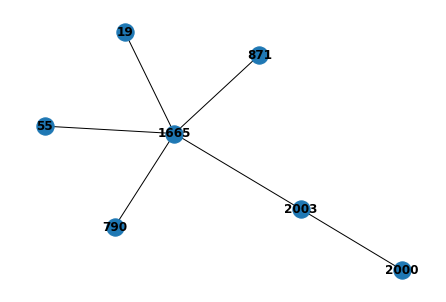

tensor([[1665, 2000,  790,  871,   55,   19],
        [2003, 2003, 1665, 1665, 1665, 1665]])
f1_score, ged 0.16666666666666666 6.0
[0.3718431  0.19479473 0.3718431  0.19479473]


<Figure size 432x288 with 0 Axes>

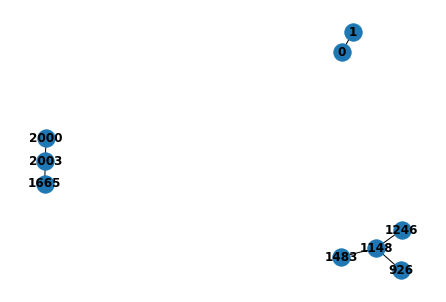

tensor([[1665, 2000,    0, 1148, 1148, 1148],
        [2003, 2003,    1, 1483, 1246,  926]])
f1_score, ged 0.16666666666666666 10.0
[]


<Figure size 432x288 with 0 Axes>

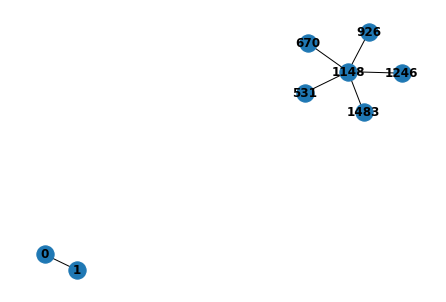

tensor([[   0, 1148, 1148, 1148, 1148, 1148],
        [   1, 1483, 1246,  926,  670,  531]])
f1_score, ged 0 9.0
[]


<Figure size 432x288 with 0 Axes>

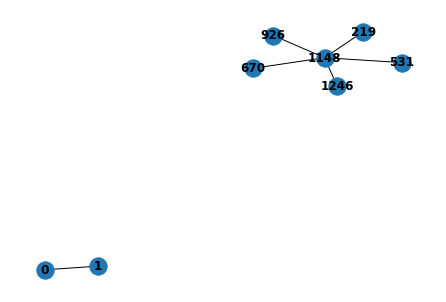

tensor([[   0, 1148, 1148, 1148, 1148, 1148],
        [   1, 1246,  926,  670,  531,  219]])
f1_score, ged 0 9.0
[]


<Figure size 432x288 with 0 Axes>

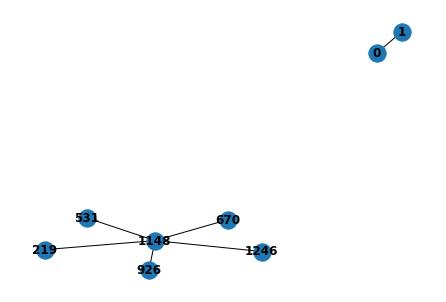

tensor([[   0, 1148, 1148, 1148, 1148, 1148],
        [   1, 1246,  926,  670,  531,  219]])
f1_score, ged 0 9.0
[0.12149023 0.12149023 0.12149023 0.12149023 0.12149023 0.12149023
 0.12149023 0.12149023 0.12149023 0.12149023 0.44292311 0.30224955
 0.44292311 0.30224955]


<Figure size 432x288 with 0 Axes>

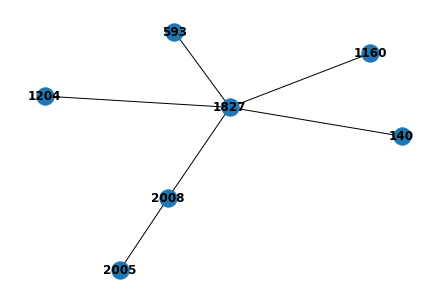

tensor([[1827, 2005, 1160,  140,  593, 1204],
        [2008, 2008, 1827, 1827, 1827, 1827]])
f1_score, ged 0.16666666666666666 6.0
[0.3718431  0.19479473 0.3718431  0.19479473]


<Figure size 432x288 with 0 Axes>

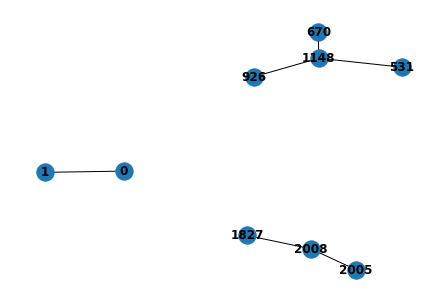

tensor([[1827, 2005,    0, 1148, 1148, 1148],
        [2008, 2008,    1,  926,  670,  531]])
f1_score, ged 0.16666666666666666 10.0
[]


<Figure size 432x288 with 0 Axes>

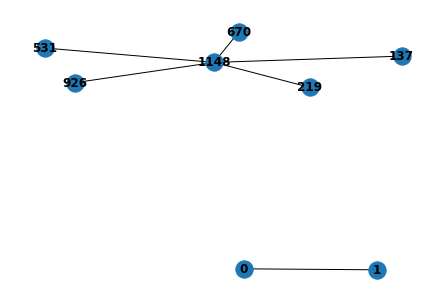

tensor([[   0, 1148, 1148, 1148, 1148, 1148],
        [   1,  926,  670,  531,  219,  137]])
f1_score, ged 0 9.0
[]


<Figure size 432x288 with 0 Axes>

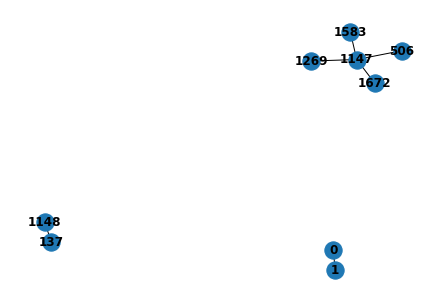

tensor([[   0, 1148, 1147, 1147, 1147, 1147],
        [   1,  137, 1672, 1583, 1269,  506]])
f1_score, ged 0 10.0
[]


<Figure size 432x288 with 0 Axes>

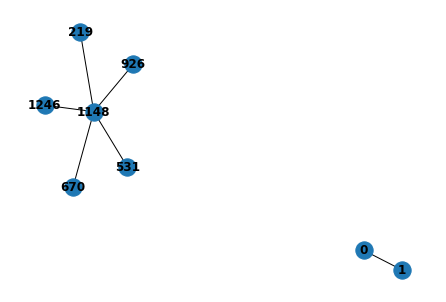

tensor([[   0, 1148, 1148, 1148, 1148, 1148],
        [   1, 1246,  926,  670,  531,  219]])
f1_score, ged 0 9.0
[0.3718431  0.19479473 0.3718431  0.19479473]


<Figure size 432x288 with 0 Axes>

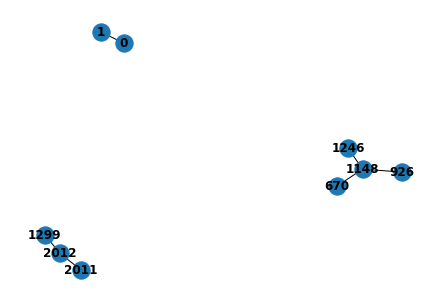

tensor([[1299, 2011,    0, 1148, 1148, 1148],
        [2012, 2012,    1, 1246,  926,  670]])
f1_score, ged 0.16666666666666666 10.0
[0.12149023 0.12149023 0.12149023 0.12149023 0.12149023 0.12149023
 0.12149023 0.12149023 0.12149023 0.12149023 0.44292311 0.30224955
 0.44292311 0.30224955]


<Figure size 432x288 with 0 Axes>

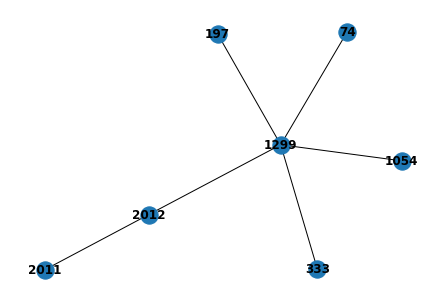

tensor([[1299, 2011, 1054,  197,  333,   74],
        [2012, 2012, 1299, 1299, 1299, 1299]])
f1_score, ged 0.16666666666666666 6.0
[]


<Figure size 432x288 with 0 Axes>

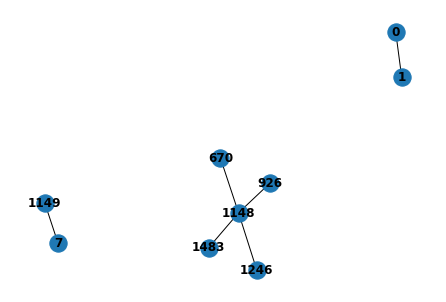

tensor([[   0, 1149, 1148, 1148, 1148, 1148],
        [   1,    7, 1483, 1246,  926,  670]])
f1_score, ged 0 10.0
[]


<Figure size 432x288 with 0 Axes>

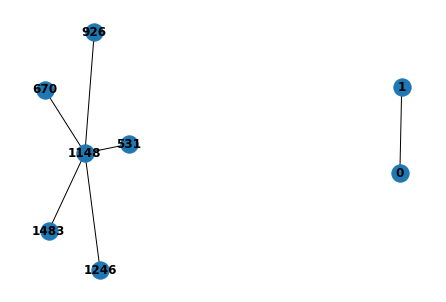

tensor([[   0, 1148, 1148, 1148, 1148, 1148],
        [   1, 1483, 1246,  926,  670,  531]])
f1_score, ged 0 9.0
[]


<Figure size 432x288 with 0 Axes>

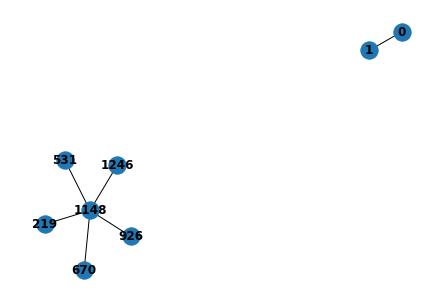

tensor([[   0, 1148, 1148, 1148, 1148, 1148],
        [   1, 1246,  926,  670,  531,  219]])
f1_score, ged 0 9.0
[0.3718431  0.19479473 0.3718431  0.19479473]


<Figure size 432x288 with 0 Axes>

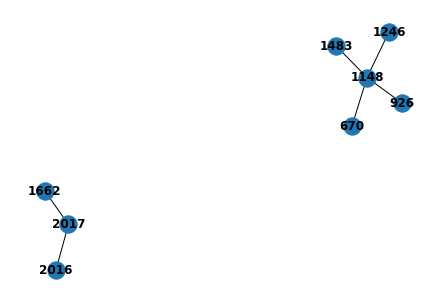

tensor([[1662, 2016, 1148, 1148, 1148, 1148],
        [2017, 2017, 1483, 1246,  926,  670]])
f1_score, ged 0.16666666666666666 9.0
[0.12149023 0.12149023 0.12149023 0.12149023 0.12149023 0.12149023
 0.12149023 0.12149023 0.12149023 0.12149023 0.44292311 0.30224955
 0.44292311 0.30224955]


<Figure size 432x288 with 0 Axes>

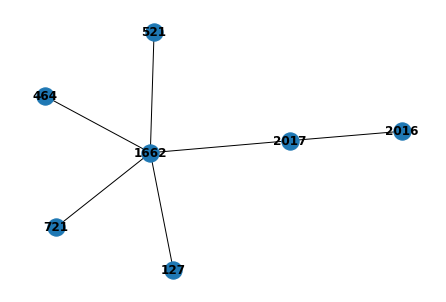

tensor([[1662, 2016,  127,  721,  521,  464],
        [2017, 2017, 1662, 1662, 1662, 1662]])
f1_score, ged 0.16666666666666666 6.0
[]


<Figure size 432x288 with 0 Axes>

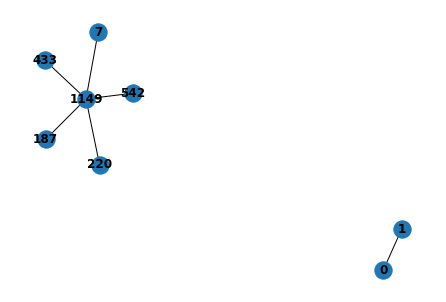

tensor([[   0, 1149, 1149, 1149, 1149, 1149],
        [   1,  542,  433,  220,  187,    7]])
f1_score, ged 0 9.0
[]


<Figure size 432x288 with 0 Axes>

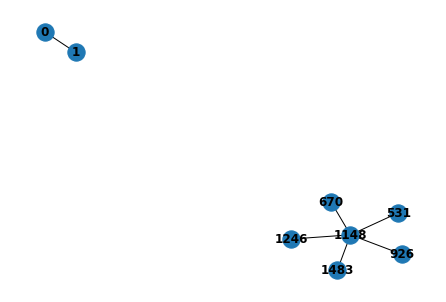

tensor([[   0, 1148, 1148, 1148, 1148, 1148],
        [   1, 1483, 1246,  926,  670,  531]])
f1_score, ged 0 9.0
[]


<Figure size 432x288 with 0 Axes>

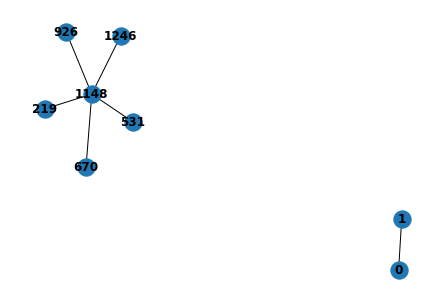

tensor([[   0, 1148, 1148, 1148, 1148, 1148],
        [   1, 1246,  926,  670,  531,  219]])
f1_score, ged 0 9.0
[0.49985737 0.03925937 0.49985737 0.03925937]


<Figure size 432x288 with 0 Axes>

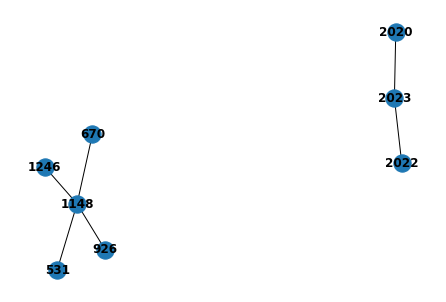

tensor([[2020, 2022, 1148, 1148, 1148, 1148],
        [2023, 2023, 1246,  926,  670,  531]])
f1_score, ged 0.3333333333333333 9.0
[0.06171907 0.02807346 0.03380493 0.05345029 0.03299023 0.05345029
 0.03380493 0.04780739 0.03380493 0.02807346 0.03299023 0.02807346
 0.02807346 0.02807346 0.03380493 0.03299023 0.03380493 0.03299023
 0.02807346 0.02807346 0.02807346 0.02807346 0.02807346 0.02807346
 0.02807346 0.02807346 0.02807346 0.02807346 0.02807346 0.02807346
 0.02807346 0.02807346 0.02807346 0.02807346 0.02807346 0.02807346
 0.02807346 0.02807346 0.02807346 0.02807346 0.02807346 0.02807346
 0.02807346 0.02807346 0.02807346 0.03299023 0.02807346 0.03380493
 0.03380493 0.03380493 0.03380493 0.03380493 0.03380493 0.03380493
 0.03380493 0.03380493 0.03380493 0.03380493 0.03380493 0.03380493
 0.03380493 0.03380493 0.03380493 0.03380493 0.03380493 0.02807346
 0.03380493 0.03299023 0.03299023 0.03299023 0.03299023 0.03299023
 0.03299023 0.03299023 0.03299023 0.03299023 0.03299023 0.03299023

<Figure size 432x288 with 0 Axes>

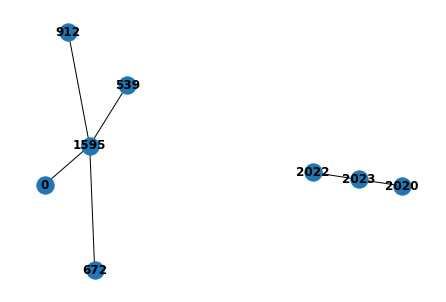

tensor([[2020,  912,  672,    0,  539, 2022],
        [2023, 1595, 1595, 1595, 1595, 2023]])
f1_score, ged 0.3333333333333333 9.0
[]


<Figure size 432x288 with 0 Axes>

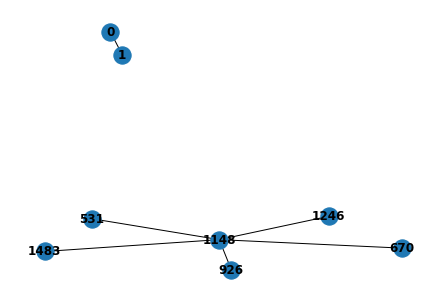

tensor([[   0, 1148, 1148, 1148, 1148, 1148],
        [   1, 1483, 1246,  926,  670,  531]])
f1_score, ged 0 9.0
[]


<Figure size 432x288 with 0 Axes>

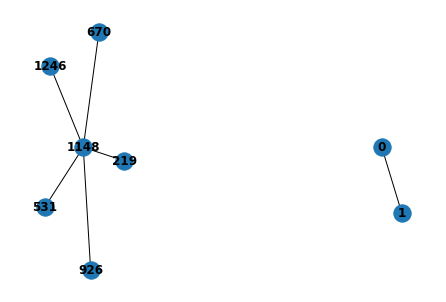

tensor([[   0, 1148, 1148, 1148, 1148, 1148],
        [   1, 1246,  926,  670,  531,  219]])
f1_score, ged 0 9.0
[]


<Figure size 432x288 with 0 Axes>

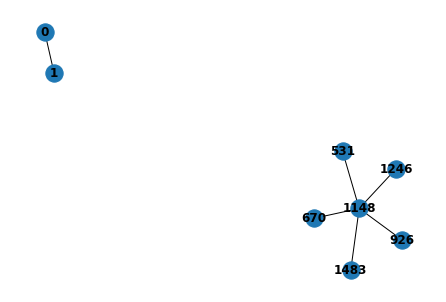

tensor([[   0, 1148, 1148, 1148, 1148, 1148],
        [   1, 1483, 1246,  926,  670,  531]])
f1_score, ged 0 9.0
[0.3718431  0.19479473 0.3718431  0.19479473]


<Figure size 432x288 with 0 Axes>

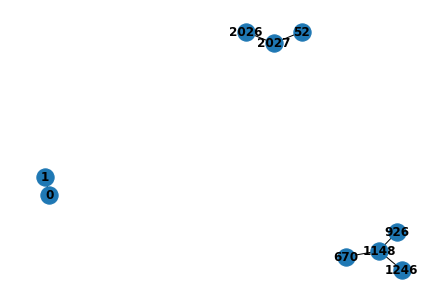

tensor([[  52, 2026,    0, 1148, 1148, 1148],
        [2027, 2027,    1, 1246,  926,  670]])
f1_score, ged 0.16666666666666666 10.0
[0.05046595 0.05046595 0.05046595 0.05046595 0.05046595 0.05046595
 0.05046595 0.05046595 0.05046595 0.05046595 0.05046595 0.05046595
 0.05046595 0.05046595 0.05046595 0.05046595 0.05046595 0.05046595
 0.05046595 0.05046595 0.05046595 0.05046595 0.05046595 0.05046595
 0.05046595 0.05046595 0.05046595 0.05046595 0.05046595 0.05046595
 0.05046595 0.05046595 0.05046595 0.05046595 0.05046595 0.05046595
 0.05046595 0.05046595 0.05046595 0.05046595 0.05046595 0.05046595
 0.05046595 0.05046595 0.05046595 0.05046595 0.05046595 0.05046595
 0.38900179 0.05046595 0.05046595 0.05046595 0.05046595 0.05046595
 0.05046595 0.05046595 0.05046595 0.05046595 0.05046595 0.05046595
 0.05046595 0.05046595 0.05046595 0.05046595 0.05046595 0.05046595
 0.05046595 0.05046595 0.05046595 0.05046595 0.05046595 0.05046595
 0.05046595 0.05046595 0.05046595 0.05046595 0.05046595 0.050465

<Figure size 432x288 with 0 Axes>

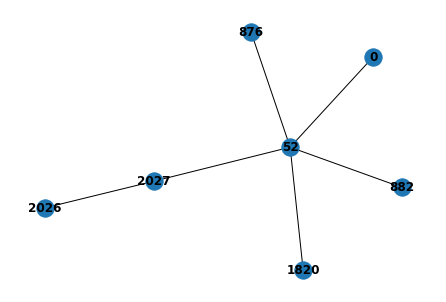

tensor([[  52, 2026,   52,   52,    0,   52],
        [2027, 2027, 1820,  876,   52,  882]])
f1_score, ged 0.16666666666666666 6.0
[0.01317584 0.6426307  0.74559513 0.51727328 0.6426307  0.38622118
 0.46784016 0.01317584 0.38622118 0.48918561 0.74559513 0.48918561
 0.51727328 0.46784016]


<Figure size 432x288 with 0 Axes>

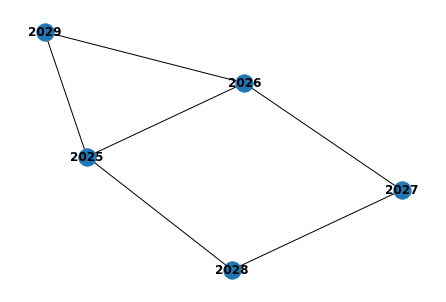

tensor([[2025, 2025, 2025, 2027, 2026, 2026],
        [2028, 2026, 2029, 2028, 2029, 2027]])
f1_score, ged 1.0 0.0
[]


<Figure size 432x288 with 0 Axes>

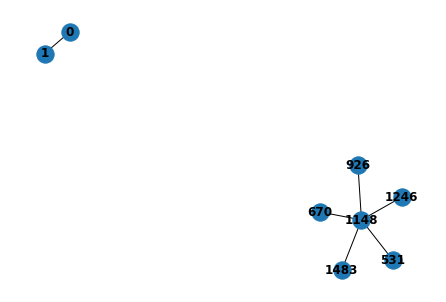

tensor([[   0, 1148, 1148, 1148, 1148, 1148],
        [   1, 1483, 1246,  926,  670,  531]])
f1_score, ged 0 9.0
[]


<Figure size 432x288 with 0 Axes>

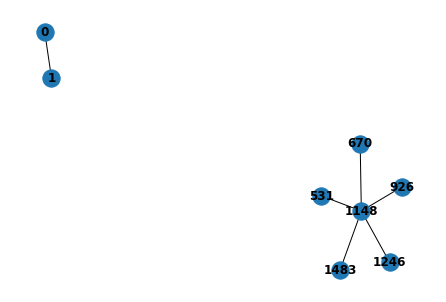

tensor([[   0, 1148, 1148, 1148, 1148, 1148],
        [   1, 1483, 1246,  926,  670,  531]])
f1_score, ged 0 9.0
[0.0283384  0.0148225  0.05768001 0.05768001 0.0283384  0.0283384
 0.0283384  0.0283384  0.0431609  0.0283384  0.0283384  0.0283384
 0.0283384  0.0283384  0.0283384  0.0283384  0.0283384  0.0283384
 0.0283384  0.0283384  0.0283384  0.0283384  0.0283384  0.0283384
 0.0283384  0.0283384  0.0283384  0.0283384  0.0283384  0.0283384
 0.0283384  0.0148225  0.0283384  0.0148225  0.05768001 0.0283384
 0.0148225  0.03412396 0.0283384  0.0148225  0.0431609  0.0148225
 0.0148225  0.0148225  0.0148225  0.0148225  0.0148225  0.0148225
 0.0148225  0.0148225  0.0148225  0.0148225  0.0148225  0.0148225
 0.0148225  0.0148225  0.0148225  0.0148225  0.0148225  0.0148225
 0.0148225  0.0148225  0.0148225  0.0148225  0.0148225  0.0148225
 0.0148225  0.0148225  0.0148225  0.0148225  0.0148225  0.0148225
 0.0148225  0.0148225  0.0148225  0.0148225  0.0148225  0.0148225
 0.0148225  0.0148225  0.0148

<Figure size 432x288 with 0 Axes>

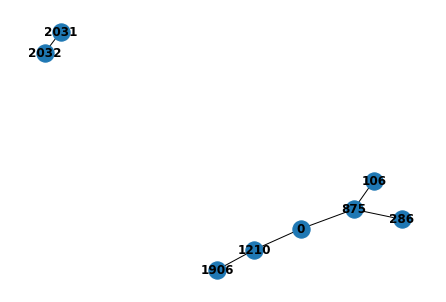

tensor([[2031,    0, 1210,  286,    0,  106],
        [2032,  875, 1906,  875, 1210,  875]])
f1_score, ged 0.16666666666666666 7.0
[0.49985737 0.49985737 0.03925937 0.03925937]


<Figure size 432x288 with 0 Axes>

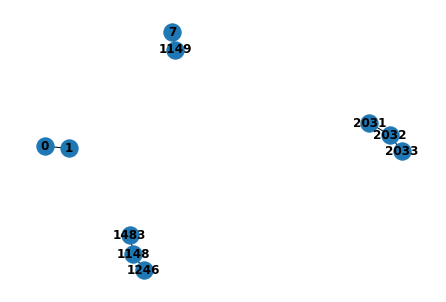

tensor([[2031, 2032,    0, 1149, 1148, 1148],
        [2032, 2033,    1,    7, 1483, 1246]])
f1_score, ged 0.3333333333333333 11.0
[]


<Figure size 432x288 with 0 Axes>

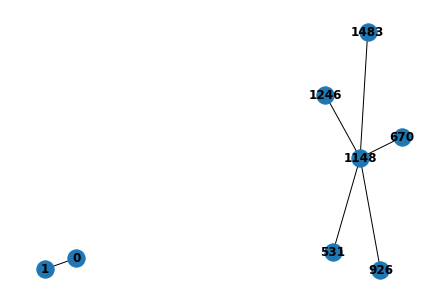

tensor([[   0, 1148, 1148, 1148, 1148, 1148],
        [   1, 1483, 1246,  926,  670,  531]])
f1_score, ged 0 9.0
[]


<Figure size 432x288 with 0 Axes>

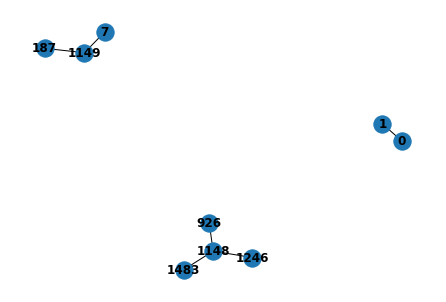

tensor([[   0, 1149, 1149, 1148, 1148, 1148],
        [   1,  187,    7, 1483, 1246,  926]])
f1_score, ged 0 10.0
[]


<Figure size 432x288 with 0 Axes>

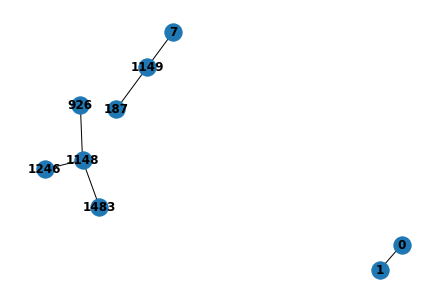

tensor([[   0, 1149, 1149, 1148, 1148, 1148],
        [   1,  187,    7, 1483, 1246,  926]])
f1_score, ged 0 10.0
[0.10033855 0.10033855 0.10033855 0.10033855 0.10033855 0.10033855
 0.10033855 0.10033855 0.10033855 0.10033855 0.10033855 0.10033855
 0.10033855 0.57628608 0.10033855 0.10033855 0.10033855 1.16342726
 1.11492842 1.16342726 1.16342726 0.90339622 0.95189506 0.90339622
 0.85489738 1.11492842 0.85489738 0.57628608 1.16342726 0.95189506]


<Figure size 432x288 with 0 Axes>

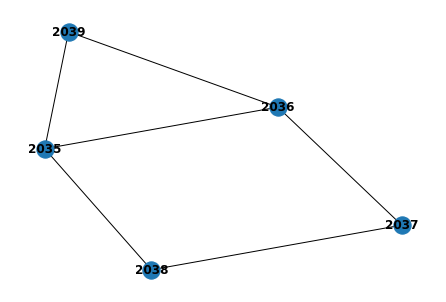

tensor([[2035, 2035, 2035, 2036, 2036, 2037],
        [2036, 2039, 2038, 2039, 2037, 2038]])
f1_score, ged 1.0 0.0
[0.10033855 0.10033855 0.10033855 0.10033855 0.10033855 0.10033855
 0.10033855 0.10033855 0.10033855 0.10033855 0.10033855 0.10033855
 0.10033855 0.57628608 0.10033855 0.10033855 0.10033855 1.16342726
 0.90339622 0.95189506 1.16342726 1.11492842 1.16342726 1.11492842
 0.85489738 0.90339622 0.85489738 0.57628608 0.95189506 1.16342726]


<Figure size 432x288 with 0 Axes>

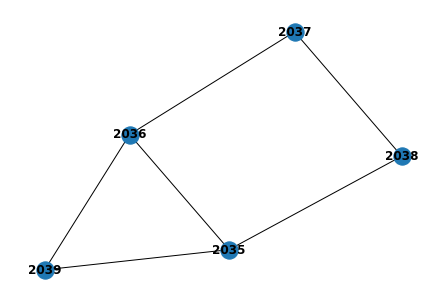

tensor([[2036, 2035, 2036, 2035, 2035, 2037],
        [2039, 2036, 2037, 2039, 2038, 2038]])
f1_score, ged 1.0 0.0
[]


<Figure size 432x288 with 0 Axes>

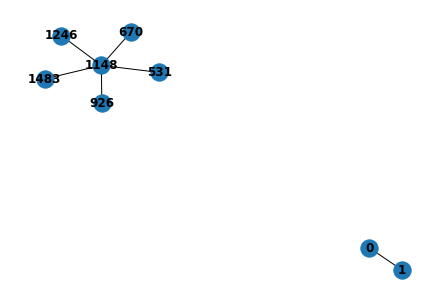

tensor([[   0, 1148, 1148, 1148, 1148, 1148],
        [   1, 1483, 1246,  926,  670,  531]])
f1_score, ged 0 9.0
[]


<Figure size 432x288 with 0 Axes>

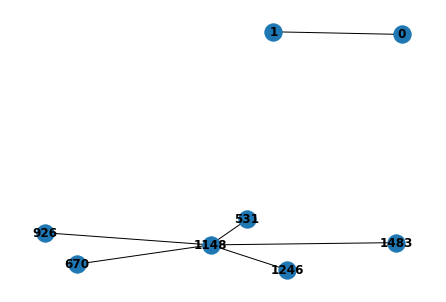

tensor([[   0, 1148, 1148, 1148, 1148, 1148],
        [   1, 1483, 1246,  926,  670,  531]])
f1_score, ged 0 9.0
[]


<Figure size 432x288 with 0 Axes>

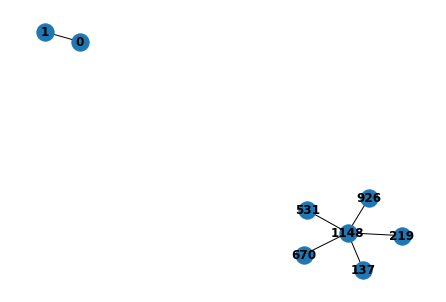

tensor([[   0, 1148, 1148, 1148, 1148, 1148],
        [   1,  926,  670,  531,  219,  137]])
f1_score, ged 0 9.0
[0.00906867 0.01131443 0.01241778 0.00906867 0.00906867 0.00906867
 0.01131443 0.00906867 0.01131443 0.01241778 0.01131443 0.00906867
 0.00906867 0.00906867 0.00906867 0.00906867 0.00906867 0.00906867
 0.02038309 0.00906867 0.00906867 0.02148645 0.00906867 0.00906867
 0.00906867 0.00906867 0.00906867 0.00906867 0.00906867 0.00906867
 0.00906867 0.00906867 0.00906867 0.00906867 0.00906867 0.00906867
 0.00906867 0.00906867 0.00906867 0.00906867 0.00906867 0.00906867
 0.00906867 0.00906867 0.00906867 0.00906867 0.00906867 0.00906867
 0.00906867 0.00906867 0.00906867 0.00906867 0.00906867 0.00906867
 0.00906867 0.00906867 0.00906867 0.00906867 0.00906867 0.00906867
 0.00906867 0.00906867 0.00906867 0.00906867 0.00906867 0.00906867
 0.00906867 0.00906867 0.00906867 0.00906867 0.00906867 0.00906867
 0.00906867 0.00906867 0.00906867 0.00906867 0.00906867 0.00906867
 0.00906867 0.00

<Figure size 432x288 with 0 Axes>

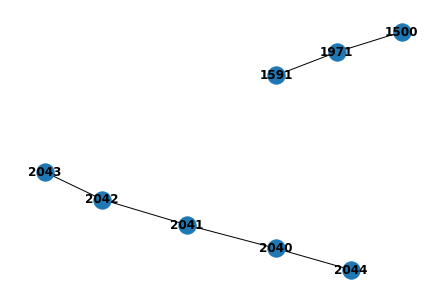

tensor([[2041, 2042, 2040, 2040, 1500, 1591],
        [2042, 2043, 2041, 2044, 1971, 1971]])
f1_score, ged 0.6666666666666666 7.0
[0.04492909 0.04492909 0.56909777 0.02104423 0.56909777 0.14665738
 0.14665738 0.02104423]


<Figure size 432x288 with 0 Axes>

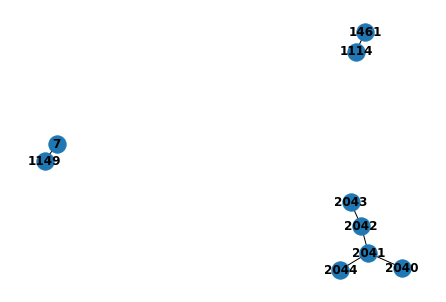

tensor([[2041, 2042, 2040, 2041, 1114, 1149],
        [2042, 2043, 2041, 2044, 1461,    7]])
f1_score, ged 0.6666666666666666 8.0
[]


<Figure size 432x288 with 0 Axes>

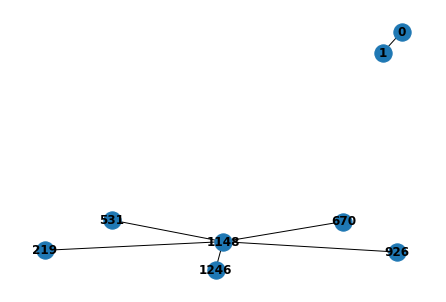

tensor([[   0, 1148, 1148, 1148, 1148, 1148],
        [   1, 1246,  926,  670,  531,  219]])
f1_score, ged 0 9.0
[]


<Figure size 432x288 with 0 Axes>

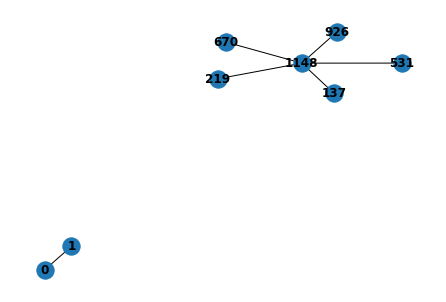

tensor([[   0, 1148, 1148, 1148, 1148, 1148],
        [   1,  926,  670,  531,  219,  137]])
f1_score, ged 0 9.0
[]


<Figure size 432x288 with 0 Axes>

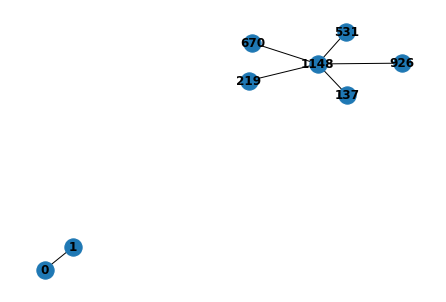

tensor([[   0, 1148, 1148, 1148, 1148, 1148],
        [   1,  926,  670,  531,  219,  137]])
f1_score, ged 0 9.0
[0.67361777 0.67361777 1.50278628 1.3348158  1.62431377 1.50278628
 1.4610613  1.69265968 1.4610613  1.29309082 1.3348158  1.29309082
 1.62431377 1.69265968]


<Figure size 432x288 with 0 Axes>

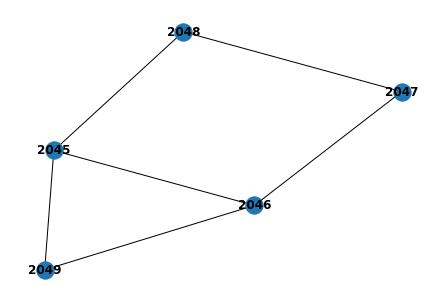

tensor([[2046, 2045, 2045, 2046, 2045, 2047],
        [2049, 2049, 2046, 2047, 2048, 2048]])
f1_score, ged 1.0 0.0
[0.04757698 0.04757698 0.04757698 0.04757698 0.04757698 0.04757698
 0.04757698 0.04757698 0.04757698 0.04757698 0.04757698 0.04757698
 0.04757698 0.04757698 0.04757698 0.04757698 0.04757698 0.04757698
 0.04757698 0.04757698 0.04757698 0.04757698 0.04757698 0.04757698
 0.04757698 0.04757698 0.04757698 0.04757698 0.49635072 0.04757698
 0.04757698 0.04757698 0.04757698 0.04757698 0.04757698 0.04757698
 0.04757698 0.04757698 0.04757698 0.04757698 0.04757698 0.04757698
 0.04757698 0.04757698 0.04757698 0.04757698 0.04757698 0.04757698
 0.04757698 0.04757698 0.04757698 0.04757698 0.04757698 0.04757698
 0.04757698 0.49635072 1.16402626 0.84323466 1.02813816 1.16402626
 1.14669412 1.29461694 1.14669412 0.82590252 0.84323466 0.82590252
 1.02813816 1.29461694]


<Figure size 432x288 with 0 Axes>

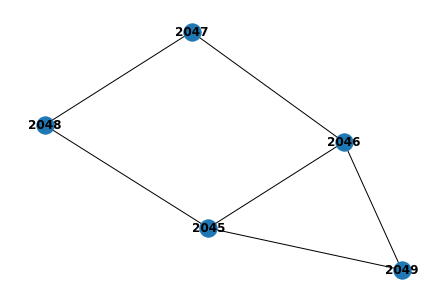

tensor([[2046, 2045, 2046, 2045, 2045, 2047],
        [2049, 2046, 2047, 2049, 2048, 2048]])
f1_score, ged 1.0 0.0
[]


<Figure size 432x288 with 0 Axes>

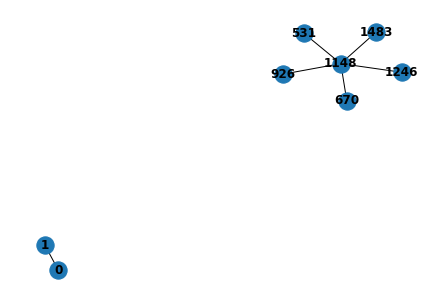

tensor([[   0, 1148, 1148, 1148, 1148, 1148],
        [   1, 1483, 1246,  926,  670,  531]])
f1_score, ged 0 9.0
[]


<Figure size 432x288 with 0 Axes>

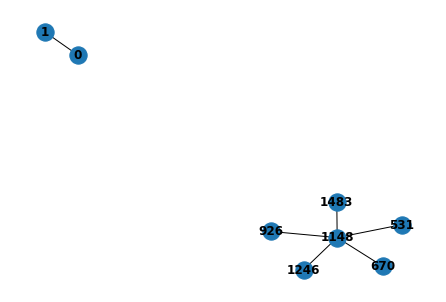

tensor([[   0, 1148, 1148, 1148, 1148, 1148],
        [   1, 1483, 1246,  926,  670,  531]])
f1_score, ged 0 9.0
[]


<Figure size 432x288 with 0 Axes>

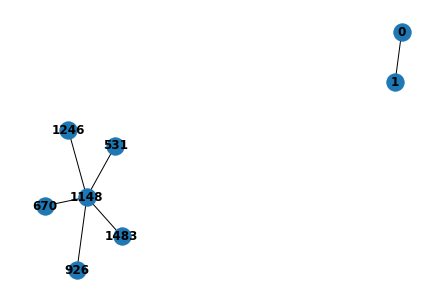

tensor([[   0, 1148, 1148, 1148, 1148, 1148],
        [   1, 1483, 1246,  926,  670,  531]])
f1_score, ged 0 9.0
[0.11123801 0.11123801 0.11123801 0.11123801 0.11123801 0.11123801
 0.11123801 0.11123801 0.11123801 0.11123801 0.11123801 0.58318091
 0.11123801 1.15363824 1.10554743 1.15363824 1.15363824 0.89579499
 0.9438858  0.89579499 0.84770417 1.10554743 0.84770417 0.58318091
 1.15363824 0.9438858 ]


<Figure size 432x288 with 0 Axes>

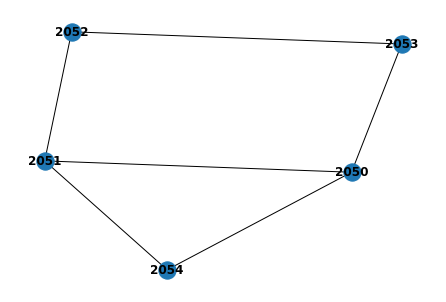

tensor([[2050, 2050, 2050, 2051, 2051, 2052],
        [2054, 2051, 2053, 2054, 2052, 2053]])
f1_score, ged 1.0 0.0
[0.11123801 0.11123801 0.11123801 0.11123801 0.11123801 0.11123801
 0.11123801 0.11123801 0.11123801 0.11123801 0.11123801 0.58318091
 0.11123801 1.15363824 0.89579499 0.9438858  1.15363824 1.10554743
 1.15363824 1.10554743 0.84770417 0.89579499 0.84770417 0.58318091
 0.9438858  1.15363824]


<Figure size 432x288 with 0 Axes>

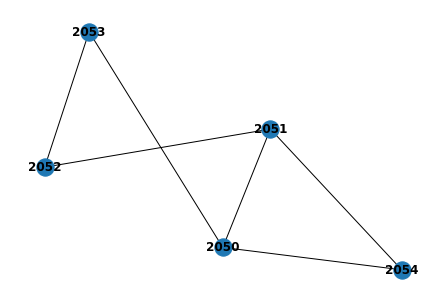

tensor([[2051, 2050, 2051, 2050, 2050, 2052],
        [2054, 2051, 2052, 2054, 2053, 2053]])
f1_score, ged 1.0 0.0
[]


<Figure size 432x288 with 0 Axes>

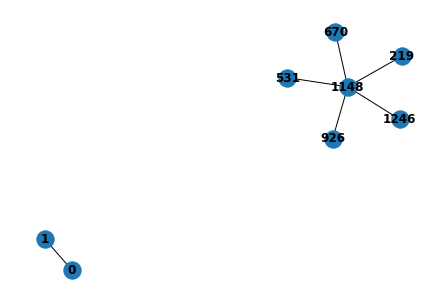

tensor([[   0, 1148, 1148, 1148, 1148, 1148],
        [   1, 1246,  926,  670,  531,  219]])
f1_score, ged 0 9.0
[]


<Figure size 432x288 with 0 Axes>

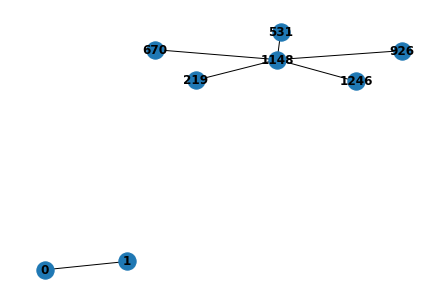

tensor([[   0, 1148, 1148, 1148, 1148, 1148],
        [   1, 1246,  926,  670,  531,  219]])
f1_score, ged 0 9.0
[]


<Figure size 432x288 with 0 Axes>

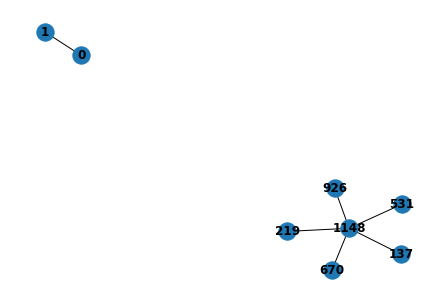

tensor([[   0, 1148, 1148, 1148, 1148, 1148],
        [   1,  926,  670,  531,  219,  137]])
f1_score, ged 0 9.0
[0.10535829 0.10535829 0.10535829 0.10535829 0.10535829 0.10535829
 0.10535829 0.10535829 0.10535829 0.10535829 0.10535829 0.10535829
 0.57947056 0.10535829 0.10535829 1.15894109 1.11062923 1.15894109
 1.15894109 0.89991269 0.94822454 0.89991269 0.85160083 1.11062923
 0.85160083 0.57947056 1.15894109 0.94822454]


<Figure size 432x288 with 0 Axes>

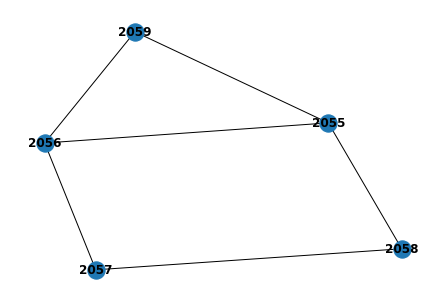

tensor([[2055, 2055, 2055, 2056, 2056, 2057],
        [2056, 2059, 2058, 2059, 2057, 2058]])
f1_score, ged 1.0 0.0
[0.10535829 0.10535829 0.10535829 0.10535829 0.10535829 0.10535829
 0.10535829 0.10535829 0.10535829 0.10535829 0.10535829 0.10535829
 0.57947056 0.10535829 0.10535829 1.15894109 0.89991269 0.94822454
 1.15894109 1.11062923 1.15894109 1.11062923 0.85160083 0.89991269
 0.85160083 0.57947056 0.94822454 1.15894109]


<Figure size 432x288 with 0 Axes>

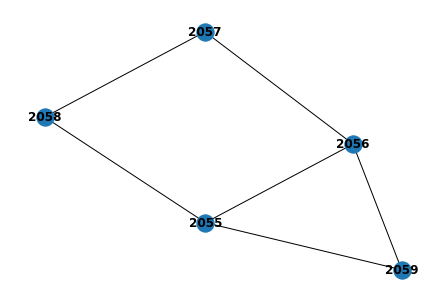

tensor([[2055, 2056, 2056, 2055, 2055, 2057],
        [2056, 2059, 2057, 2059, 2058, 2058]])
f1_score, ged 1.0 0.0
[]


<Figure size 432x288 with 0 Axes>

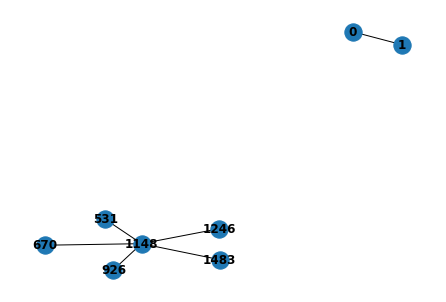

tensor([[   0, 1148, 1148, 1148, 1148, 1148],
        [   1, 1483, 1246,  926,  670,  531]])
f1_score, ged 0 9.0
[]


<Figure size 432x288 with 0 Axes>

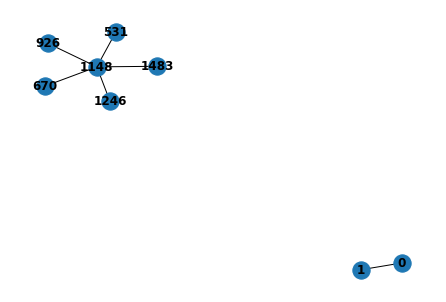

tensor([[   0, 1148, 1148, 1148, 1148, 1148],
        [   1, 1483, 1246,  926,  670,  531]])
f1_score, ged 0 9.0
[]


<Figure size 432x288 with 0 Axes>

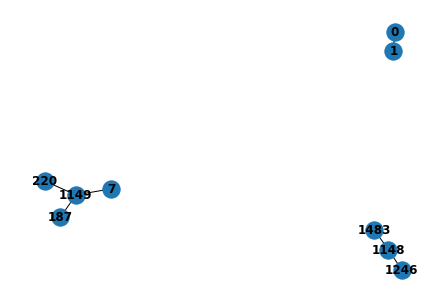

tensor([[   0, 1149, 1149, 1149, 1148, 1148],
        [   1,  220,  187,    7, 1483, 1246]])
f1_score, ged 0 10.0
[0.5388674  0.09981796 0.5388674  0.09981796]


<Figure size 432x288 with 0 Axes>

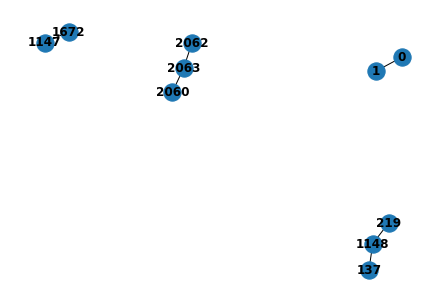

tensor([[2060, 2062,    0, 1148, 1148, 1147],
        [2063, 2063,    1,  219,  137, 1672]])
f1_score, ged 0.3333333333333333 11.0
[0.01308176 0.01033577 0.01033577 0.03832606 0.01308176 0.01308176
 0.02341753 0.01308176 0.01308176 0.01308176 0.01308176 0.01308176
 0.01308176 0.01308176 0.01308176 0.01308176 0.01308176 0.01308176
 0.01308176 0.01308176 0.01308176 0.01308176 0.01308176 0.01308176
 0.01308176 0.01308176 0.01308176 0.01308176 0.01308176 0.01308176
 0.01308176 0.01308176 0.01308176 0.01308176 0.01308176 0.01308176
 0.01308176 0.01308176 0.01308176 0.01308176 0.01308176 0.01308176
 0.01308176 0.01308176 0.01308176 0.01308176 0.05140782 0.01308176
 0.01308176 0.01308176 0.01308176 0.01308176 0.01308176 0.01308176
 0.01308176 0.01308176 0.01308176 0.01308176 0.01308176 0.01308176
 0.01308176 0.01308176 0.01308176 0.01308176 0.01308176 0.01308176
 0.01308176 0.01308176 0.01308176 0.01308176 0.01308176 0.01308176
 0.01308176 0.01308176 0.01308176 0.01308176 0.01308176 0.0130817

<Figure size 432x288 with 0 Axes>

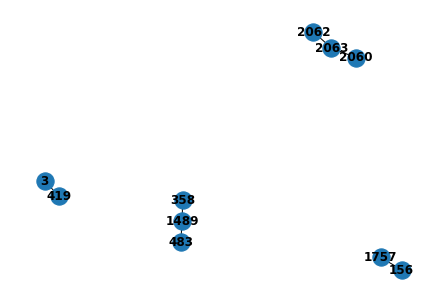

tensor([[2060, 2062,    3,  483,  358,  156],
        [2063, 2063,  419, 1489, 1489, 1757]])
f1_score, ged 0.3333333333333333 11.0
[]


<Figure size 432x288 with 0 Axes>

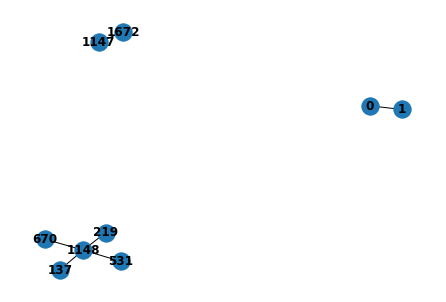

tensor([[   0, 1148, 1148, 1148, 1148, 1147],
        [   1,  670,  531,  219,  137, 1672]])
f1_score, ged 0 10.0
[]


<Figure size 432x288 with 0 Axes>

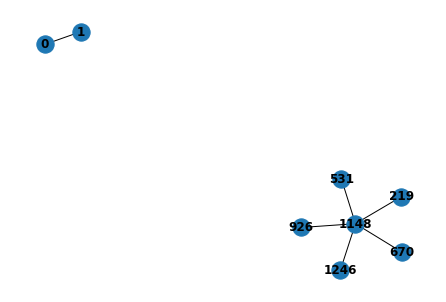

tensor([[   0, 1148, 1148, 1148, 1148, 1148],
        [   1, 1246,  926,  670,  531,  219]])
f1_score, ged 0 9.0
[]


<Figure size 432x288 with 0 Axes>

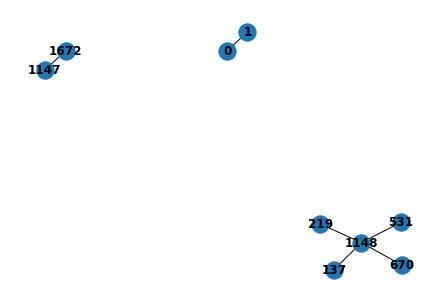

tensor([[   0, 1148, 1148, 1148, 1148, 1147],
        [   1,  670,  531,  219,  137, 1672]])
f1_score, ged 0 10.0
[0.04173717 0.04173717 0.04173717 0.04173717 0.04173717 0.04173717
 0.04173717 0.04173717 0.04173717 0.04173717 0.04173717 0.04173717
 0.04173717 0.04173717 0.04173717 0.04173717 0.04173717 0.04173717
 0.04173717 0.04173717 0.04173717 0.04173717 0.04173717 0.04173717
 0.04173717 0.04173717 0.04173717 0.04173717 0.04173717 0.04173717
 0.04173717 0.04173717 0.04173717 0.04173717 0.04173717 0.04173717
 0.04173717 0.04173717 0.04173717 0.04173717 0.04173717 0.49239448
 0.04173717 0.04173717 0.04173717 0.04173717 0.04173717 0.04173717
 0.04173717 0.04173717 0.04173717 0.04173717 0.04173717 0.04173717
 0.04173717 0.04173717 0.04173717 0.04173717 0.04173717 0.04173717
 0.04173717 0.04173717 0.04173717 0.04173717 0.04173717 0.04173717
 0.04173717 0.04173717 0.04173717 0.04173717 0.04173717 0.04173717
 0.04173717 1.16891181 1.1515069  1.30005056 0.49239448 1.16891181
 0.84677374 1.0

<Figure size 432x288 with 0 Axes>

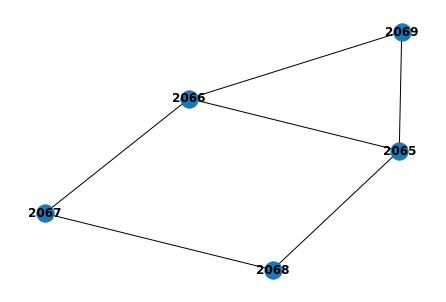

tensor([[2065, 2065, 2065, 2066, 2066, 2067],
        [2069, 2066, 2068, 2069, 2067, 2068]])
f1_score, ged 1.0 0.0
[0.89444894 1.9073174  1.81966275 2.10810441 0.89444894 1.9073174
 1.69812042 2.05867249 1.69812042 1.61046576 1.81966275 1.61046576
 2.10810441 2.05867249]


<Figure size 432x288 with 0 Axes>

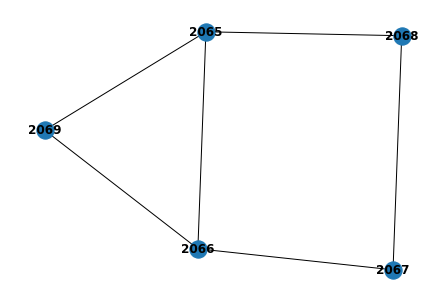

tensor([[2065, 2066, 2065, 2065, 2066, 2067],
        [2069, 2069, 2066, 2068, 2067, 2068]])
f1_score, ged 1.0 0.0
[]


<Figure size 432x288 with 0 Axes>

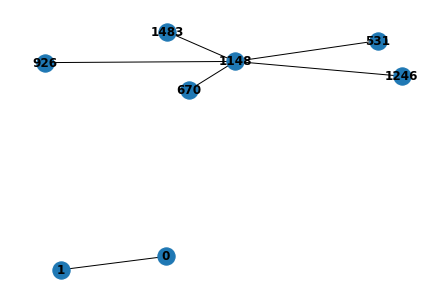

tensor([[   0, 1148, 1148, 1148, 1148, 1148],
        [   1, 1483, 1246,  926,  670,  531]])
f1_score, ged 0 9.0
[]


<Figure size 432x288 with 0 Axes>

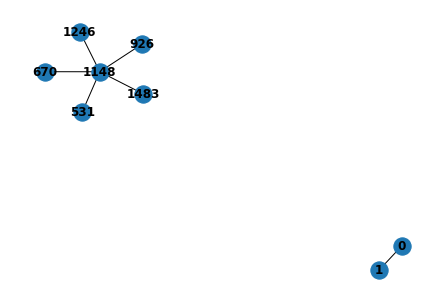

tensor([[   0, 1148, 1148, 1148, 1148, 1148],
        [   1, 1483, 1246,  926,  670,  531]])
f1_score, ged 0 9.0
[]


<Figure size 432x288 with 0 Axes>

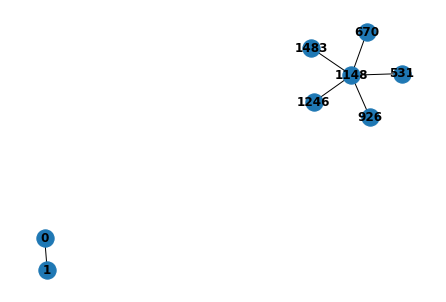

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [28]:
list_node_idx = range(n_basis,n_basis+500)#*n_shapes)
F1_scores = []
GED = []
Recall = []
Precision = []

for node_idx in list_node_idx:
    edge_mask = explain_sa_node(model, node_idx, data.x, data.edge_index, target = labels[node_idx])
    print(edge_mask[np.where(edge_mask>0)[0]])
    edge_mask = mask_to_directed(edge_mask, data.edge_index)
    recall, precision, f1_score, ged = evaluate(node_idx, data, edge_mask, num_top_edges = 6)
    indices = (-edge_mask).argsort()[:6]
    print(data.edge_index[:,indices])
    Recall.append(recall)
    Precision.append(precision)
    F1_scores.append(f1_score)
    GED.append(ged)
    print("f1_score, ged", f1_score, ged)

In [29]:
print(np.mean(F1_scores), np.mean(GED), np.mean(Recall), np.mean(Precision))

0.22946859903381642 7.521739130434782 0.22946859903381642 0.22946859903381642


In [30]:
def explain_ig_node(model, node_idx, x, edge_index, target, include_edges=None):
    ig = IntegratedGradients(model_forward_node)
    input_mask = x.clone().requires_grad_(True).to(device)
    ig_mask = ig.attribute(input_mask, target=target, additional_forward_args=(model, edge_index, node_idx),
                           internal_batch_size=input_mask.shape[0])

    node_attr = ig_mask.cpu().detach().numpy().sum(axis=1)
    edge_mask = node_attr_to_edge(edge_index, node_attr)
    return edge_mask

[0.09808938 0.09808938 0.09808938 0.09808938 0.09808938 0.09808938
 0.09808938 0.09808938 0.09808938 0.09808938 0.36301241 0.99358245
 0.82659427 1.06039932 0.99358245 0.73708231 0.93063929 0.73708231
 0.57009413 0.36301241 0.82659427 0.57009413 1.06039932 0.93063929]


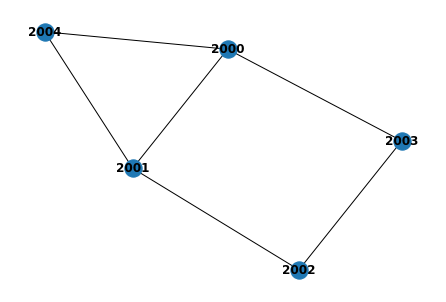

tensor([[2000, 2000, 2001, 2000, 2001, 2002],
        [2004, 2001, 2004, 2003, 2002, 2003]])
f1_score, ged 1.0 0.0
[0.29690394 1.02450091 0.72817839 0.92926728 1.02450091 0.93539022
 1.09121929 0.93539022 0.6390677  0.29690394 0.72817839 0.6390677
 0.92926728 1.09121929]


<Figure size 432x288 with 0 Axes>

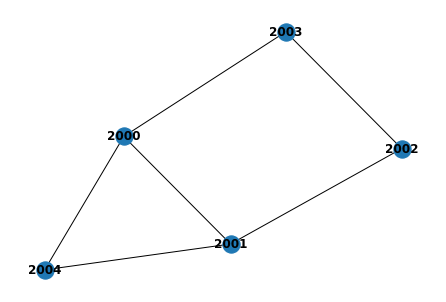

tensor([[2001, 2000, 2001, 2000, 2000, 2002],
        [2004, 2001, 2002, 2004, 2003, 2003]])
f1_score, ged 1.0 0.0
[0.00438616 0.00438616 0.00438616 0.00438616 0.00438616 0.00438616
 0.00438616 0.00438616 0.00438616 0.00438616 0.01677148 0.00710391
 0.01554696 0.0001124  0.00710391 0.01519439 0.00089305 0.01519439
 0.02363744 0.01677148 0.01554696 0.02363744 0.0001124  0.00089305]


<Figure size 432x288 with 0 Axes>

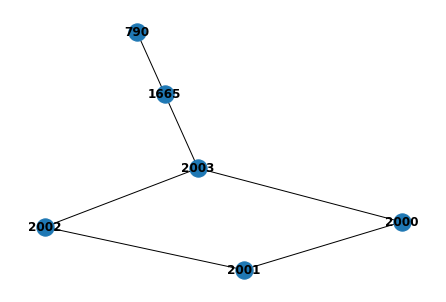

tensor([[2002, 1665, 2000, 2001, 2000,  790],
        [2003, 2003, 2003, 2002, 2001, 1665]])
f1_score, ged 0.6666666666666666 3.0
[0.00037775 0.00072897 0.00072897 0.00037775 0.00138792 0.00138792
 0.00037775 0.00037775 0.00037775 0.00072897 0.00037775 0.00037775
 0.00037775 0.00037775 0.00037775 0.00037775 0.00037775 0.00037775
 0.00037775 0.00037775 0.00037775 0.00037775 0.00037775 0.00037775
 0.00037775 0.00037775 0.00037775 0.00037775 0.00037775 0.00037775
 0.00037775 0.00037775 0.00037775 0.00037775 0.00037775 0.00037775
 0.00037775 0.00037775 0.00037775 0.00037775 0.00037775 0.00037775
 0.00037775 0.00037775 0.00037775 0.00037775 0.00037775 0.00037775
 0.00037775 0.00037775 0.00037775 0.00037775 0.00037775 0.00037775
 0.00037775 0.00037775 0.00037775 0.00037775 0.00037775 0.00037775
 0.00037775 0.00037775 0.00037775 0.00037775 0.00037775 0.00037775
 0.00037775 0.00037775 0.00037775 0.00037775 0.00037775 0.00037775
 0.00037775 0.00037775 0.00037775 0.00037775 0.00037775 0.00037775

<Figure size 432x288 with 0 Axes>

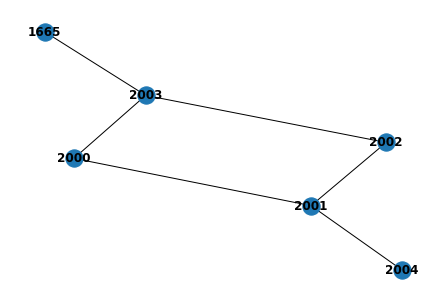

tensor([[2002, 2000, 1665, 2001, 2000, 2001],
        [2003, 2003, 2003, 2002, 2001, 2004]])
f1_score, ged 0.8333333333333334 3.0
[]


<Figure size 432x288 with 0 Axes>

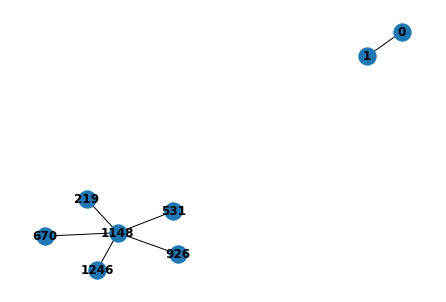

tensor([[   0, 1148, 1148, 1148, 1148, 1148],
        [   1, 1246,  926,  670,  531,  219]])
f1_score, ged 0 9.0
[0.09808938 0.09808938 0.09808938 0.09808938 0.09808938 0.09808938
 0.09808938 0.09808938 0.09808938 0.09808938 0.36301241 0.99358245
 0.82659427 1.06039932 0.99358245 0.73708231 0.93063929 0.73708231
 0.57009413 0.36301241 0.82659427 0.57009413 1.06039932 0.93063929]


<Figure size 432x288 with 0 Axes>

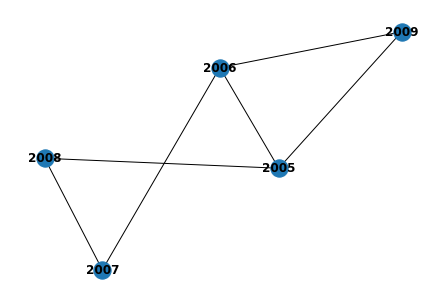

tensor([[2005, 2005, 2006, 2005, 2006, 2007],
        [2009, 2006, 2009, 2008, 2007, 2008]])
f1_score, ged 1.0 0.0
[0.29690394 1.02450091 0.72817839 0.92926728 1.02450091 0.93539022
 1.09121929 0.93539022 0.6390677  0.29690394 0.72817839 0.6390677
 0.92926728 1.09121929]


<Figure size 432x288 with 0 Axes>

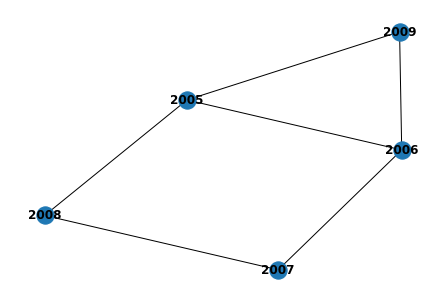

tensor([[2006, 2005, 2006, 2005, 2005, 2007],
        [2009, 2006, 2007, 2009, 2008, 2008]])
f1_score, ged 1.0 0.0
[0.00438616 0.00438616 0.00438616 0.00438616 0.00438616 0.00438616
 0.00438616 0.00438616 0.00438616 0.00438616 0.01677148 0.00710391
 0.01554696 0.0001124  0.00710391 0.01519439 0.00089305 0.01519439
 0.02363744 0.01677148 0.01554696 0.02363744 0.0001124  0.00089305]


<Figure size 432x288 with 0 Axes>

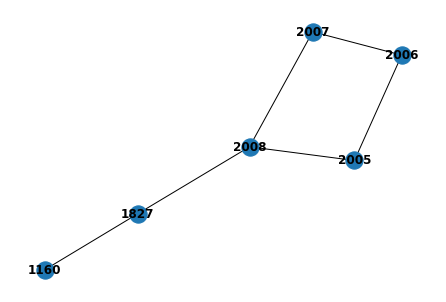

tensor([[2007, 1827, 2005, 2006, 2005, 1160],
        [2008, 2008, 2008, 2007, 2006, 1827]])
f1_score, ged 0.6666666666666666 3.0
[0.00070252 0.00114721 0.0012168  0.00070252 0.00070252 0.00070252
 0.0012168  0.0012168  0.00130082 0.00070252 0.00070252 0.00070252
 0.00070252 0.00070252 0.00070252 0.00070252 0.00070252 0.00070252
 0.00070252 0.00070252 0.00070252 0.00070252 0.00070252 0.00070252
 0.00070252 0.00070252 0.00070252 0.00070252 0.00070252 0.00070252
 0.00070252 0.00070252 0.00460162 0.00130082 0.00070252 0.0012168
 0.0012168  0.0012168  0.00130082 0.00114721 0.00130082 0.00070252
 0.00070252 0.00130082 0.00070252 0.00130082 0.00130082 0.00130082
 0.00130082 0.00130082 0.00519991 0.00114721 0.00070252 0.00070252
 0.00114721 0.00070252 0.00070252 0.00070252 0.0012168  0.00070252
 0.00070252 0.00114721 0.0012168  0.00070252 0.00070252 0.00070252
 0.00070252 0.00114721 0.00114721 0.00114721 0.00114721 0.00114721
 0.00114721 0.00114721 0.00504631 0.00070252 0.00070252 0.0012168
 

<Figure size 432x288 with 0 Axes>

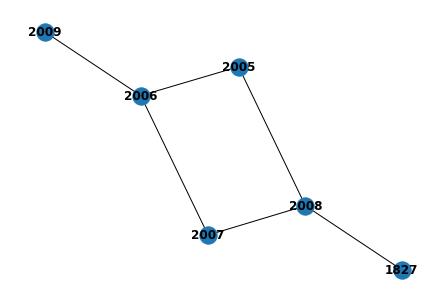

tensor([[2007, 2005, 1827, 2006, 2005, 2006],
        [2008, 2008, 2008, 2007, 2006, 2009]])
f1_score, ged 0.8333333333333334 3.0
[]


<Figure size 432x288 with 0 Axes>

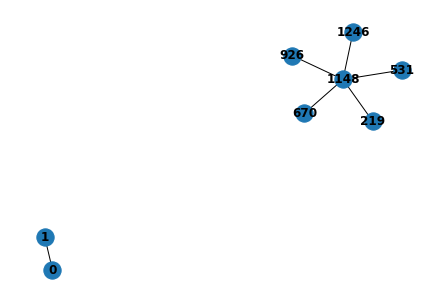

tensor([[   0, 1148, 1148, 1148, 1148, 1148],
        [   1, 1246,  926,  670,  531,  219]])
f1_score, ged 0 9.0
[0.29690394 1.02450091 0.93539022 1.09121929 1.02450091 0.72817839
 0.92926728 0.29690394 0.72817839 0.6390677  0.93539022 0.6390677
 1.09121929 0.92926728]


<Figure size 432x288 with 0 Axes>

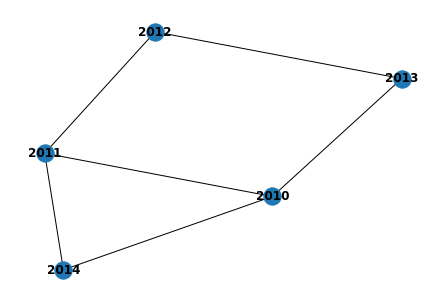

tensor([[2010, 2010, 2010, 2011, 2011, 2012],
        [2014, 2011, 2013, 2014, 2012, 2013]])
f1_score, ged 1.0 0.0
[0.09808938 0.09808938 0.09808938 0.09808938 0.09808938 0.09808938
 0.09808938 0.09808938 0.09808938 0.09808938 0.36301241 0.99358245
 0.73708231 0.93063929 0.99358245 0.82659427 1.06039932 0.36301241
 0.82659427 0.57009413 0.73708231 0.57009413 0.93063929 1.06039932]


<Figure size 432x288 with 0 Axes>

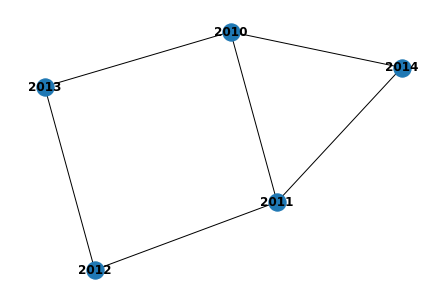

tensor([[2011, 2010, 2010, 2011, 2010, 2012],
        [2014, 2011, 2014, 2012, 2013, 2013]])
f1_score, ged 1.0 0.0
[0.00063225 0.00121067 0.00069898 0.00108285 0.00063225 0.00063225
 0.00063225 0.00069898 0.00139796 0.00063225 0.00069898 0.00063225
 0.00063225 0.00063225 0.00063225 0.00063225 0.00063225 0.00063225
 0.00063225 0.00063225 0.00063225 0.00063225 0.00063225 0.00063225
 0.00063225 0.00063225 0.00063225 0.00063225 0.00063225 0.00063225
 0.00063225 0.00063225 0.00063225 0.00063225 0.00063225 0.00063225
 0.00063225 0.00063225 0.00063225 0.00063225 0.00063225 0.00063225
 0.00063225 0.0064466  0.00063225 0.00063225 0.00063225 0.00063225
 0.00063225 0.00063225 0.00063225 0.00063225 0.00063225 0.00063225
 0.00069898 0.00108285 0.00063225 0.00069898 0.00121067 0.00069898
 0.00069898 0.00069898 0.00069898 0.00069898 0.00069898 0.00069898
 0.00069898 0.00069898 0.00069898 0.00069898 0.00069898 0.00069898
 0.00069898 0.00069898 0.00069898 0.00069898 0.00069898 0.00069898
 0.00069898 0.

<Figure size 432x288 with 0 Axes>

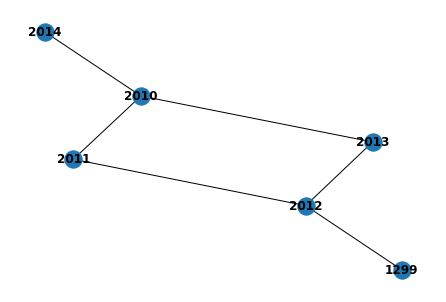

tensor([[2012, 2011, 2010, 1299, 2010, 2010],
        [2013, 2012, 2013, 2012, 2011, 2014]])
f1_score, ged 0.8333333333333334 3.0
[0.00438616 0.00438616 0.00438616 0.00438616 0.00438616 0.00438616
 0.00438616 0.00438616 0.00438616 0.00438616 0.01677148 0.00710391
 0.01519439 0.00089305 0.00710391 0.01554696 0.0001124  0.01677148
 0.01554696 0.02363744 0.01519439 0.02363744 0.00089305 0.0001124 ]


<Figure size 432x288 with 0 Axes>

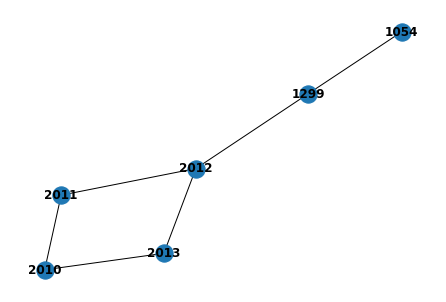

tensor([[2012, 1299, 2011, 2010, 2010, 1054],
        [2013, 2012, 2012, 2013, 2011, 1299]])
f1_score, ged 0.6666666666666666 3.0
[]


<Figure size 432x288 with 0 Axes>

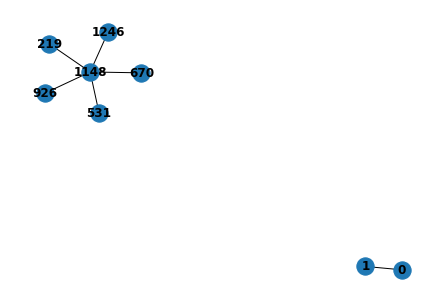

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [31]:
list_node_idx = range(n_basis,n_basis+20)#*n_shapes)
F1_scores = []
GED = []
Recall = []
Precision = []

for node_idx in list_node_idx:
    edge_mask = explain_ig_node(model, node_idx, data.x, data.edge_index, labels[node_idx])
    print(edge_mask[np.where(edge_mask>0)[0]])
    edge_mask = mask_to_directed(edge_mask, data.edge_index)
    recall, precision, f1_score, ged = evaluate(node_idx, data, edge_mask, num_top_edges = 6)
    indices = (-edge_mask).argsort()[:6]
    print(data.edge_index[:,indices])
    Recall.append(recall)
    Precision.append(precision)
    F1_scores.append(f1_score)
    GED.append(ged)
    print("f1_score, ged", f1_score, ged)

In [141]:
print(np.mean(F1_scores), np.mean(GED), np.mean(Recall), np.mean(Precision))

0.8333333333333334 1.8571428571428572 0.8333333333333334 0.8333333333333334


In [32]:
def explain_occlusion(model, node_idx, x, edge_index, target, include_edges=None):
    depth_limit = model.num_layers + 1
    data = Data(x=x, edge_index=edge_index)
    pred_prob = model(data.x, data.edge_index)[node_idx][target].item()
    g = to_networkx(data)
    subgraph_nodes = []
    for k, v in nx.shortest_path_length(g, target=node_idx).items():
        if v < depth_limit:
            subgraph_nodes.append(k)
    subgraph = g.subgraph(subgraph_nodes)
    edge_occlusion_mask = np.ones(data.num_edges, dtype=bool)
    edge_mask = np.zeros(data.num_edges)
    edge_index_numpy = data.edge_index.cpu().numpy()
    for i in range(data.num_edges):
        if include_edges is not None and not include_edges[i].item():
            continue
        u, v = list(edge_index_numpy[:, i])
        if (u, v) in subgraph.edges():
            edge_occlusion_mask[i] = False
            prob = model(data.x, data.edge_index[:, edge_occlusion_mask])[node_idx][target].item()
            edge_mask[i] = pred_prob - prob
            edge_occlusion_mask[i] = True
    return edge_mask


[0.01549125 0.4204604  0.17534226 0.18984991 0.4204604  0.05009085
 0.34293252 0.18984991 0.4264254 ]


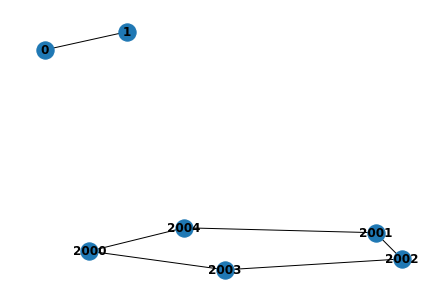

tensor([[2000, 2001, 2001, 2002, 2000,    0],
        [2004, 2004, 2002, 2003, 2003,    1]])
f1_score, ged 0.8333333333333334 4.0
[0.12051469 0.41694516 0.07163423 0.1895954  0.41694516 0.18146259
 0.07163423 0.1895954  0.10912126 0.18146259]


<Figure size 432x288 with 0 Axes>

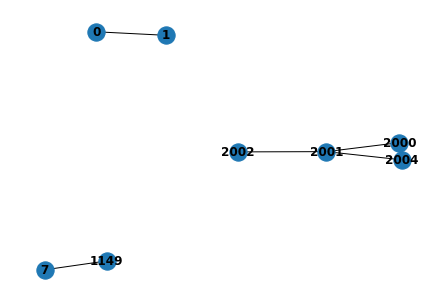

tensor([[2000, 2001, 2001, 2000,    0, 1149],
        [2004, 2004, 2002, 2001,    1,    7]])
f1_score, ged 0.6666666666666666 7.0
[0.02603137 0.00718439 0.46472955 0.23338819 0.46472955 0.00308192
 0.23338819 0.7114867  0.23338819]


<Figure size 432x288 with 0 Axes>

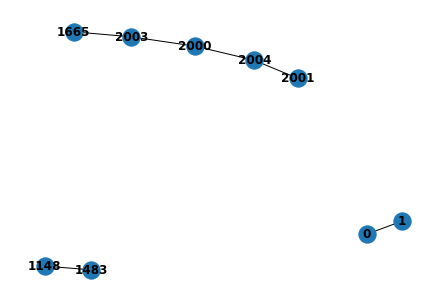

tensor([[2000, 2001, 1665, 2000,    0, 1148],
        [2004, 2004, 2003, 2003,    1, 1483]])
f1_score, ged 0.5 8.0
[1.67100430e-02 9.87148285e-03 2.71797180e-05 1.99079514e-04
 1.48463249e-03 1.48463249e-03 1.48463249e-03 6.90361261e-02
 5.58915138e-02 1.61062956e-01 9.20534134e-03 2.72258520e-02
 1.61062956e-01 5.58915138e-02 2.18153000e-04 9.20534134e-03
 2.72258520e-02 5.58915138e-02]


<Figure size 432x288 with 0 Axes>

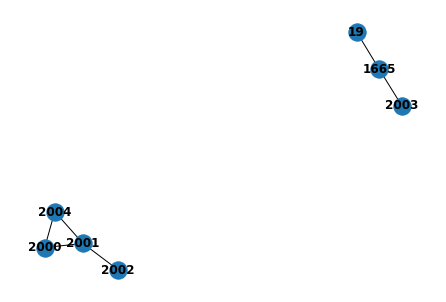

tensor([[2000, 2001, 1665, 2000, 2001,   19],
        [2004, 2004, 2003, 2001, 2002, 1665]])
f1_score, ged 0.6666666666666666 6.0
[0.03252065 0.02846277 0.49933362 0.14103723 0.2866776  0.103526
 0.02269602 0.02846277 0.14103723 0.2866776  0.14032996 0.02269602]


<Figure size 432x288 with 0 Axes>

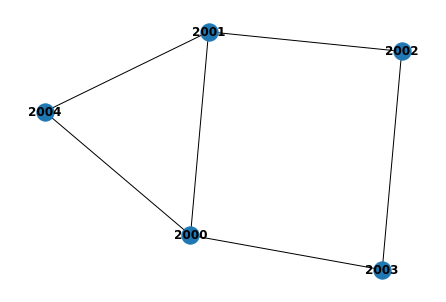

tensor([[2000, 2001, 2001, 2000, 2000, 2002],
        [2004, 2002, 2004, 2001, 2003, 2003]])
f1_score, ged 1.0 0.0
[0.01549125 0.4204604  0.17534226 0.18984991 0.4204604  0.05009085
 0.34293252 0.18984991 0.4264254 ]


<Figure size 432x288 with 0 Axes>

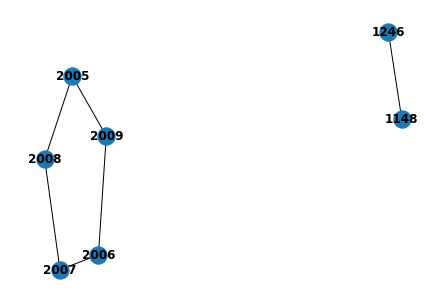

tensor([[2006, 2005, 2006, 2007, 2005, 1148],
        [2009, 2009, 2007, 2008, 2008, 1246]])
f1_score, ged 0.8333333333333334 4.0
[0.12051469 0.41694516 0.07163423 0.1895954  0.41694516 0.18146259
 0.07163423 0.1895954  0.10912126 0.18146259]


<Figure size 432x288 with 0 Axes>

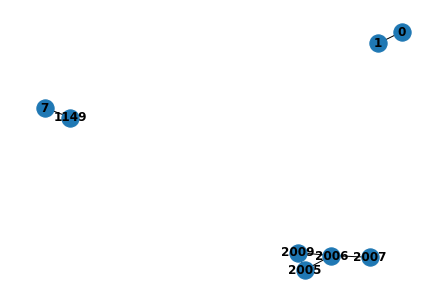

tensor([[2006, 2005, 2006, 2005,    0, 1149],
        [2009, 2009, 2007, 2006,    1,    7]])
f1_score, ged 0.6666666666666666 7.0
[0.02603137 0.00718439 0.46472955 0.23338819 0.46472955 0.00308192
 0.23338819 0.7114867  0.23338819]


<Figure size 432x288 with 0 Axes>

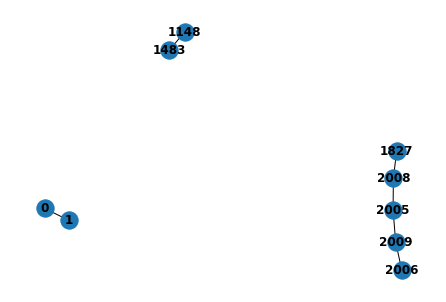

tensor([[2006, 2005, 1827, 2005,    0, 1148],
        [2009, 2009, 2008, 2008,    1, 1483]])
f1_score, ged 0.5 8.0
[0.01272047 0.00222707 0.00063252 0.00063252 0.00029409 0.00203836
 0.00135851 0.00164139 0.00164139 0.05118978 0.05576301 0.154006
 0.01026452 0.03008842 0.154006   0.05576301 0.01026452 0.03008842
 0.05576301]


<Figure size 432x288 with 0 Axes>

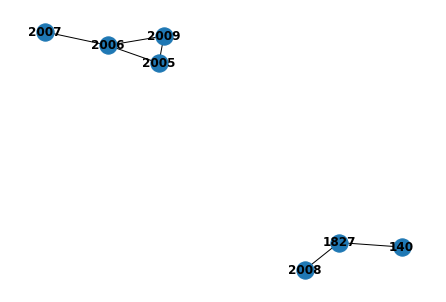

tensor([[2006, 2005, 2005, 1827, 2006,  140],
        [2009, 2009, 2006, 2008, 2007, 1827]])
f1_score, ged 0.6666666666666666 6.0
[0.03252065 0.02846277 0.49933362 0.14103723 0.2866776  0.103526
 0.02269602 0.02846277 0.14103723 0.2866776  0.14032996 0.02269602]


<Figure size 432x288 with 0 Axes>

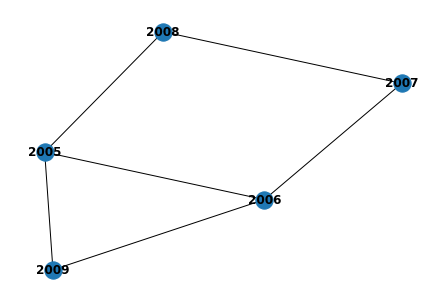

tensor([[2005, 2006, 2006, 2005, 2007, 2005],
        [2009, 2007, 2009, 2006, 2008, 2008]])
f1_score, ged 1.0 0.0
[0.07163423 0.1895954  0.41694516 0.12051469 0.41694516 0.07163423
 0.1895954  0.18146259 0.18146259 0.10912126]


<Figure size 432x288 with 0 Axes>

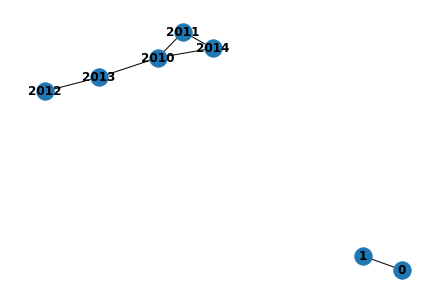

tensor([[2010, 2011, 2010, 2012, 2010,    0],
        [2014, 2014, 2013, 2013, 2011,    1]])
f1_score, ged 0.8333333333333334 4.0
[0.17534226 0.18984991 0.4204604  0.01549125 0.4204604  0.34293252
 0.18984991 0.05009085 0.4264254 ]


<Figure size 432x288 with 0 Axes>

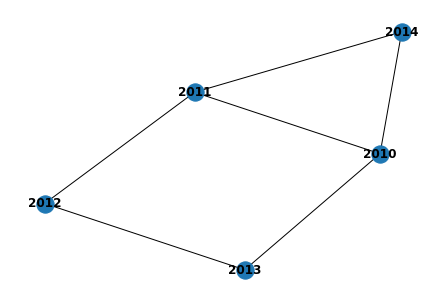

tensor([[2010, 2011, 2010, 2012, 2010, 2011],
        [2014, 2014, 2013, 2013, 2011, 2012]])
f1_score, ged 1.0 0.0
[1.03420019e-02 9.20665264e-03 2.82919407e-03 7.63416290e-04
 9.97781754e-05 1.35302544e-04 5.19633293e-04 7.36594200e-04
 1.16193295e-03 7.75719881e-02 8.66246223e-03 2.57548094e-02
 1.64820671e-01 5.59939146e-02 1.64820671e-01 8.66246223e-03
 2.57548094e-02 5.59939146e-02 5.59473038e-03 5.59939146e-02]


<Figure size 432x288 with 0 Axes>

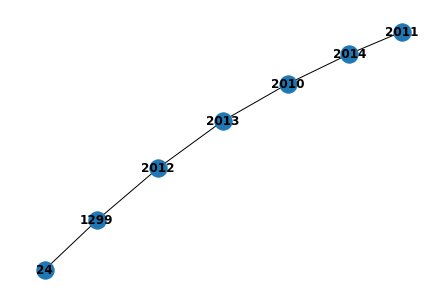

tensor([[2011, 2010, 1299, 2012, 2010,   24],
        [2014, 2014, 2012, 2013, 2013, 1299]])
f1_score, ged 0.6666666666666666 6.0
[0.02603137 0.23338819 0.46472955 0.00718439 0.46472955 0.00308192
 0.23338819 0.7114867  0.23338819]


<Figure size 432x288 with 0 Axes>

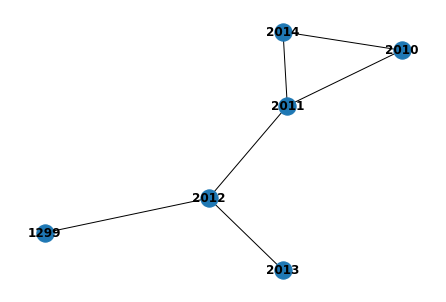

tensor([[2012, 2010, 2011, 2010, 1299, 2011],
        [2013, 2014, 2014, 2011, 2012, 2012]])
f1_score, ged 0.8333333333333334 3.0
[0.14103723 0.2866776  0.103526   0.03252065 0.02846277 0.49933362
 0.14103723 0.2866776  0.02269602 0.02846277 0.02269602 0.14032996]


<Figure size 432x288 with 0 Axes>

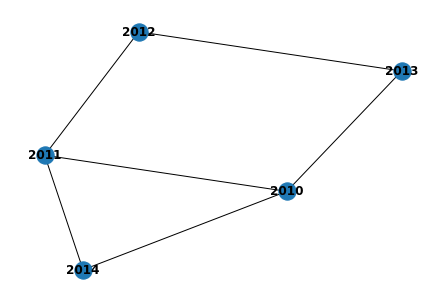

tensor([[2011, 2010, 2012, 2010, 2010, 2011],
        [2014, 2013, 2013, 2011, 2014, 2012]])
f1_score, ged 1.0 0.0
[0.07163423 0.1895954  0.41694516 0.12051469 0.41694516 0.07163423
 0.1895954  0.18146259 0.18146259 0.10912126]


<Figure size 432x288 with 0 Axes>

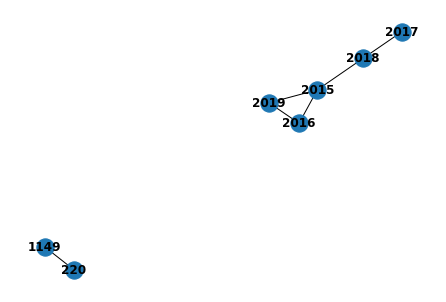

tensor([[2016, 2015, 2015, 2017, 2015, 1149],
        [2019, 2019, 2018, 2018, 2016,  220]])
f1_score, ged 0.8333333333333334 4.0
[0.17534226 0.18984991 0.4204604  0.01549125 0.4204604  0.34293252
 0.18984991 0.05009085 0.4264254 ]


<Figure size 432x288 with 0 Axes>

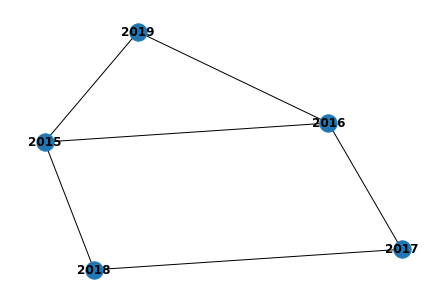

tensor([[2015, 2016, 2015, 2017, 2015, 2016],
        [2019, 2019, 2018, 2018, 2016, 2017]])
f1_score, ged 1.0 0.0
[1.22464895e-02 4.41122055e-03 7.96675682e-04 5.62334061e-03
 5.66244125e-05 3.92079353e-04 1.16348267e-03 7.37428665e-04
 3.09109688e-04 7.73830414e-02 8.67474079e-03 2.57881880e-02
 1.64734364e-01 5.59912920e-02 1.64734364e-01 8.67474079e-03
 2.57881880e-02 5.59912920e-02 5.47087193e-03 5.59912920e-02]


<Figure size 432x288 with 0 Axes>

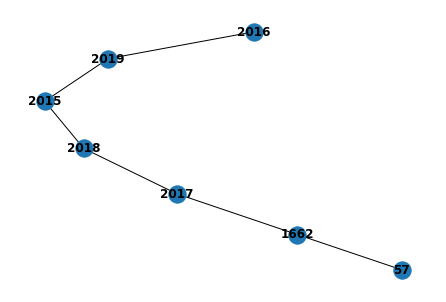

tensor([[2015, 2016, 1662, 2015, 2017,   57],
        [2019, 2019, 2017, 2018, 2018, 1662]])
f1_score, ged 0.6666666666666666 6.0
[0.02603137 0.23338819 0.46472955 0.00718439 0.46472955 0.00308192
 0.23338819 0.7114867  0.23338819]


<Figure size 432x288 with 0 Axes>

KeyboardInterrupt: 

In [33]:
list_node_idx = range(n_basis,n_basis+20)#*n_shapes)
F1_scores = []
GED = []
Recall = []
Precision = []

for node_idx in list_node_idx:
    edge_mask = explain_occlusion(model, node_idx, data.x, data.edge_index, labels[node_idx])
    print(edge_mask[np.where(edge_mask>0)[0]])
    edge_mask = mask_to_directed(edge_mask, data.edge_index)
    recall, precision, f1_score, ged = evaluate(node_idx, data, edge_mask, num_top_edges = 6)
    indices = (-edge_mask).argsort()[:6]
    print(data.edge_index[:,indices])
    Recall.append(recall)
    Precision.append(precision)
    F1_scores.append(f1_score)
    GED.append(ged)
    print("f1_score, ged", f1_score, ged)

In [144]:
print(np.mean(F1_scores), np.mean(GED), np.mean(Recall), np.mean(Precision))

0.8166666666666668 3.55 0.8166666666666668 0.8166666666666668


In [34]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class Node_Explainer:
    def __init__(
            self,
            model,
            edge_index,
            X,
            num_layers,
            mode=0,
            print_result=1
    ):
        self.model = model
        self.model.eval()
        self.edge_index = edge_index
        self.X = X
        self.num_layers = num_layers
        self.mode = mode
        self.print_result = print_result

    def perturb_features_on_node(self, feature_matrix, node_idx, random=0, mode=0):
        # return a random perturbed feature matrix
        # random = 0 for nothing, 1 for random.
        # mode = 0 for random 0-1, 1 for scaling with original feature

        X_perturb = feature_matrix
        if mode == 0:
            if random == 0:
                perturb_array = X_perturb[node_idx]
            elif random == 1:
                perturb_array = np.random.randint(2, size=X_perturb[node_idx].shape[0])
            X_perturb[node_idx] = perturb_array
        elif mode == 1:
            if random == 0:
                perturb_array = X_perturb[node_idx]
            elif random == 1:
                perturb_array = np.multiply(X_perturb[node_idx],
                                            np.random.uniform(low=0.0, high=2.0, size=X_perturb[node_idx].shape[0]))
            X_perturb[node_idx] = perturb_array
        return X_perturb

    def explain(self, node_idx, target, num_samples=100, top_node=None, p_threshold=0.05, pred_threshold=0.1):
        neighbors, _, _, _ = k_hop_subgraph(node_idx, self.num_layers, self.edge_index)
        neighbors = neighbors.cpu().detach().numpy()

        if (node_idx not in neighbors):
            neighbors = np.append(neighbors, node_idx)

        pred_torch = self.model(self.X, self.edge_index).cpu()
        soft_pred = np.asarray([softmax(np.asarray(pred_torch[node_].data)) for node_ in range(self.X.shape[0])])

        pred_node = np.asarray(pred_torch[node_idx].data)
        label_node = np.argmax(pred_node)
        soft_pred_node = softmax(pred_node)

        Samples = []
        Pred_Samples = []

        for iteration in range(num_samples):

            X_perturb = self.X.cpu().detach().numpy()
            sample = []
            for node in neighbors:
                seed = np.random.randint(2)
                if seed == 1:
                    latent = 1
                    X_perturb = self.perturb_features_on_node(X_perturb, node, random=seed)
                else:
                    latent = 0
                sample.append(latent)

            X_perturb_torch = torch.tensor(X_perturb, dtype=torch.float).to(device)
            pred_perturb_torch = self.model(X_perturb_torch, self.edge_index).cpu()
            soft_pred_perturb = np.asarray(
                [softmax(np.asarray(pred_perturb_torch[node_].data)) for node_ in range(self.X.shape[0])])

            sample_bool = []
            for node in neighbors:
                if (soft_pred_perturb[node, target] + pred_threshold) < soft_pred[node, target]:
                    sample_bool.append(1)
                else:
                    sample_bool.append(0)

            Samples.append(sample)
            Pred_Samples.append(sample_bool)

        Samples = np.asarray(Samples)
        Pred_Samples = np.asarray(Pred_Samples)
        Combine_Samples = Samples - Samples
        for s in range(Samples.shape[0]):
            Combine_Samples[s] = np.asarray(
                [Samples[s, i] * 10 + Pred_Samples[s, i] + 1 for i in range(Samples.shape[1])])

        data_pgm = pd.DataFrame(Combine_Samples)
        data_pgm = data_pgm.rename(columns={0: 'A', 1: 'B'})  # Trick to use chi_square test on first two data columns
        ind_ori_to_sub = dict(zip(neighbors, list(data_pgm.columns)))

        p_values = []
        for node in neighbors:
            if node == node_idx:
                p = 0 # p<0.05 => we are confident that we can reject the null hypothesis (i.e. the prediction is the same after perturbing the neighbouring node 
                # => this neighbour has no influence on the prediction - should not be in the explanation)
            else:
                chi2, p,_ = chi_square(ind_ori_to_sub[node], ind_ori_to_sub[node_idx], [], data_pgm, boolean=False, significance_level=0.05)
            p_values.append(p)

        pgm_stats = dict(zip(neighbors, p_values))
        return pgm_stats

In [35]:
def explain_pgmexplainer(model, node_idx, x, edge_index, target, include_edges=None):
    explainer = Node_Explainer(model, edge_index, x, model.num_layers, print_result=0)
    explanation = explainer.explain(node_idx,target)
    node_attr = np.zeros(x.shape[0])
    for node, p_value in explanation.items():
        node_attr[node] = 1 - p_value
    edge_mask = node_attr_to_edge(edge_index, node_attr)
    return edge_mask

[0.51875682 0.51875682 0.51875682 0.51875682 0.51875682 0.51875682
 0.51875682 0.51875682 0.51875682 0.51875682 1.51875682 2.
 2.         1.99999999 2.         2.         1.99999999 2.
 2.         1.51875682 2.         2.         1.99999999 1.99999999]


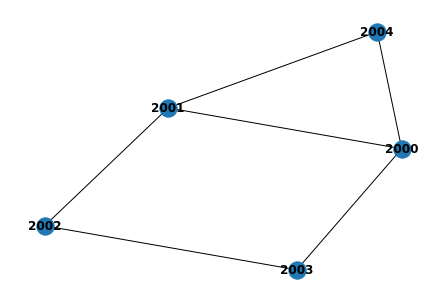

tensor([[2002, 2000, 2000, 2001, 2000, 2001],
        [2003, 2001, 2003, 2002, 2004, 2004]])
f1_score, ged 1.0 0.0
[0.49364384 1.0320932  0.52573704 0.55257066 1.0320932  1.52047746
 1.52047746 1.52047746 1.0141213  0.49364384 0.52573704 1.0141213
 0.55257066 1.52047746]


<Figure size 432x288 with 0 Axes>

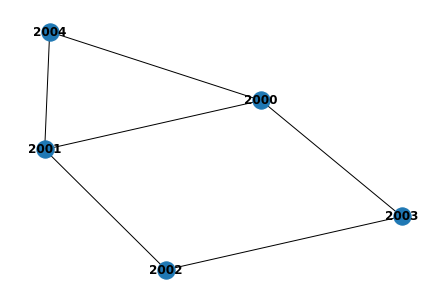

tensor([[2001, 2001, 2000, 2002, 2000, 2000],
        [2002, 2004, 2001, 2003, 2004, 2003]])
f1_score, ged 1.0 0.0
[0.045138   0.045138   0.045138   0.045138   0.045138   0.045138
 0.045138   0.045138   0.045138   0.045138   0.27226293 0.13793456
 0.22712493 0.35943989 0.13793456 1.13793456 0.49737445 1.13793456
 1.22712493 0.27226293 0.22712493 1.22712493 0.35943989 0.49737445]


<Figure size 432x288 with 0 Axes>

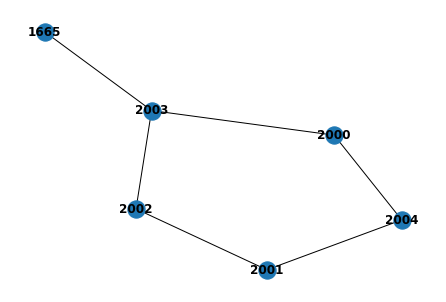

tensor([[2002, 2001, 2001, 2000, 1665, 2000],
        [2003, 2002, 2004, 2004, 2003, 2003]])
f1_score, ged 0.8333333333333334 3.0
[0.5786205  0.5786205  0.17502635 0.17502635 0.5786205  0.26998959
 0.28272525 0.5786205  0.28272525 0.90097158 0.5786205  0.5786205
 0.5786205  0.5786205  0.5786205  0.5786205  0.5786205  0.5786205
 0.5786205  0.5786205  0.5786205  0.5786205  0.5786205  0.5786205
 0.5786205  0.5786205  0.5786205  0.5786205  0.5786205  0.5786205
 0.5786205  0.5786205  0.5786205  0.84861009 0.5786205  0.5786205
 0.5786205  0.5786205  0.5786205  0.90097158 0.28272525 0.28272525
 0.5786205  0.17502635 0.5786205  0.5786205  0.17502635 0.5786205
 0.5786205  0.90097158 0.5786205  0.5786205  0.17502635 0.5786205
 0.5786205  0.28272525 0.28272525 0.28272525 0.28272525 0.28272525
 0.28272525 0.28272525 0.55271484 0.17502635 0.17502635 0.17502635
 0.17502635 0.17502635 0.17502635 0.44501594 0.90097158 0.5786205
 0.5786205  0.5786205  0.5786205  0.5786205  0.5786205  0.90097158
 0.9009

<Figure size 432x288 with 0 Axes>

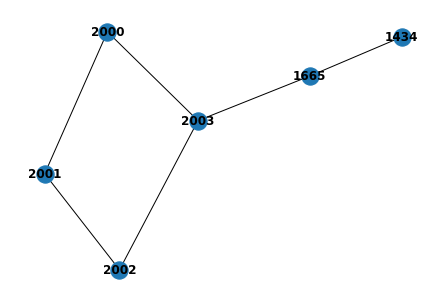

tensor([[2002, 2000, 1665, 1434, 2001, 2000],
        [2003, 2003, 2003, 1665, 2002, 2001]])
f1_score, ged 0.6666666666666666 3.0
[0.14941887 0.44898409 0.14941887 1.         0.44898409 0.88035944
 1.44898409 0.88035944 0.58079422 0.14941887 0.14941887 0.58079422
 1.         1.44898409]


<Figure size 432x288 with 0 Axes>

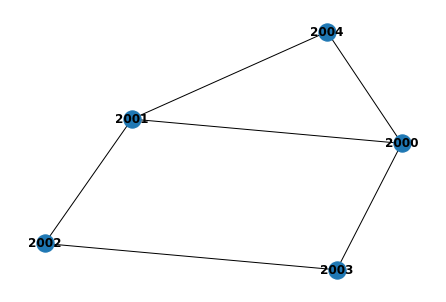

tensor([[2001, 2000, 2001, 2002, 2000, 2000],
        [2004, 2004, 2002, 2003, 2001, 2003]])
f1_score, ged 1.0 0.0
[0.59363772 0.59363772 0.59363772 0.59363772 0.59363772 0.59363772
 0.59363772 0.59363772 0.59363772 0.59363772 1.59363772 2.
 2.         1.99960565 2.         2.         1.99960565 2.
 2.         1.59363772 2.         2.         1.99960565 1.99960565]


<Figure size 432x288 with 0 Axes>

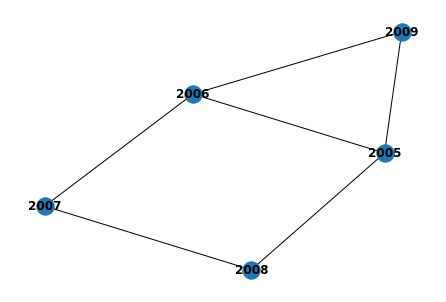

tensor([[2005, 2005, 2006, 2007, 2006, 2005],
        [2008, 2006, 2007, 2008, 2009, 2009]])
f1_score, ged 1.0 0.0


KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [36]:
import time 


list_node_idx = range(n_basis,n_basis+20)#*n_shapes)
F1_scores = []
GED = []
Recall = []
Precision = []
duration_samples = []

for node_idx in list_node_idx:
    start_time = time.time()
    edge_mask = explain_pgmexplainer(model, node_idx, data.x, data.edge_index, labels[node_idx])
    print(edge_mask[np.where(edge_mask>0)[0]])
    end_time = time.time()
    duration_seconds = end_time - start_time
    duration_samples.append(duration_seconds)
    
    edge_mask = mask_to_directed(edge_mask, data.edge_index)
    recall, precision, f1_score, ged = evaluate(node_idx, data, edge_mask, num_top_edges = 6)
    indices = (-edge_mask).argsort()[:6]
    print(data.edge_index[:,indices])
    
    Recall.append(recall)
    Precision.append(precision)
    F1_scores.append(f1_score)
    GED.append(ged)
    print("f1_score, ged", f1_score, ged)

In [ ]:
print(np.mean(F1_scores), np.mean(GED), np.mean(Recall), np.mean(Precision), np.mean(duration_samples))

In [284]:
def evaluate_subgraph(node_idx, data, G_expl):
    G_true, role = get_ground_truth_ba_shapes(node_idx)
    #nx.draw(G_true,  with_labels=True, font_weight='bold')
    #plt.figure()
    #nx.draw(G_expl,  with_labels=True, font_weight='bold')
    #plt.show()
    #plt.clf()
    return scores(G_expl, G_true)

In [80]:
print(np.mean(F1_scores), np.mean(GED), np.mean(Recall), np.mean(Precision), np.mean(duration_samples))

0.7497902097902097 1.65 0.7249999999999999 0.785357142857143 nan


/Users/kenzaamara/.conda/envs/Explain/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/kenzaamara/.conda/envs/Explain/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [44]:
def explain_random(model, node_idx, x, edge_index, target, include_edges=None):
    return np.random.uniform(size=edge_index.shape[1])

[0.29218136 0.15195296 0.23682181 ... 0.65071381 0.36042914 0.02769381]


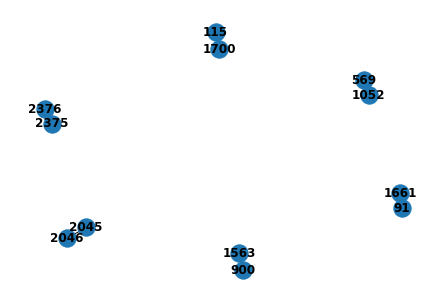

tensor([[2375,   91,  900,  569, 2045,  115],
        [2376, 1661, 1563, 1052, 2046, 1700]])
f1_score, ged 0 15.0
[0.25748322 0.55452075 0.77116991 ... 0.08410639 0.46548574 0.58332501]


<Figure size 432x288 with 0 Axes>

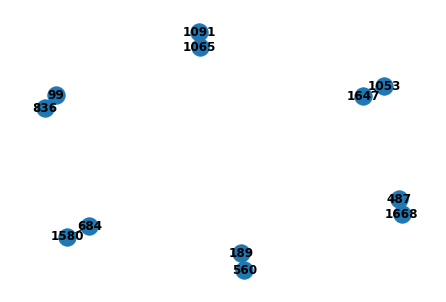

tensor([[  99,  684, 1065, 1053,  189,  487],
        [ 836, 1580, 1091, 1647,  560, 1668]])
f1_score, ged 0 15.0
[0.29058395 0.18983893 0.99145235 ... 0.82166589 0.00548186 0.03905489]


<Figure size 432x288 with 0 Axes>

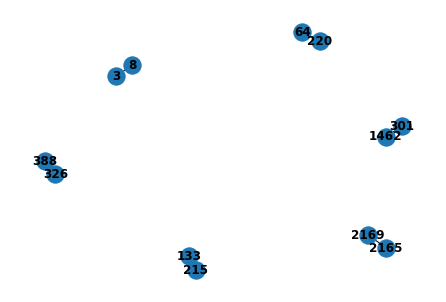

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [45]:
list_node_idx = range(n_basis,n_basis+20)#*n_shapes)
F1_scores = []
GED = []
Recall = []
Precision = []
duration_samples = []

for node_idx in list_node_idx:
    start_time = time.time()
    edge_mask = explain_random(model, node_idx, data.x, data.edge_index, labels[node_idx])
    print(edge_mask[np.where(edge_mask>0)[0]])
    end_time = time.time()
    duration_seconds = end_time - start_time
    duration_samples.append(duration_seconds)
    
    edge_mask = mask_to_directed(edge_mask, data.edge_index)
    recall, precision, f1_score, ged = evaluate(node_idx, data, edge_mask, num_top_edges = 6)
    indices = (-edge_mask).argsort()[:6]
    print(data.edge_index[:,indices])
    
    Recall.append(recall)
    Precision.append(precision)
    F1_scores.append(f1_score)
    GED.append(ged)
    print("f1_score, ged", f1_score, ged)

In [46]:
def explain_distance(model, node_idx, x, edge_index, target, include_edges=None):
    data = Data(x=x, edge_index=edge_index)
    g = to_networkx(data)
    length = nx.shortest_path_length(g, target=node_idx)

    def get_attr(node):
        if node in length:
            return 1 / (length[node] + 1)
        return 0

    edge_sources = edge_index[1].cpu().numpy()
    return np.array([get_attr(node) for node in edge_sources])

[0.16666667 0.2        0.2        ... 0.11111111 0.14285714 0.125     ]


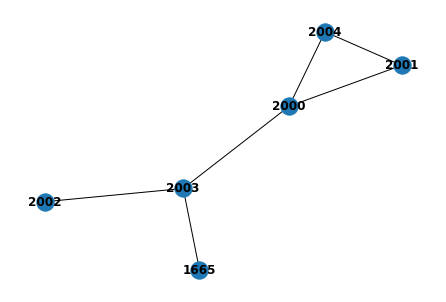

tensor([[1665, 2002, 2000, 2001, 2000, 2000],
        [2003, 2003, 2004, 2004, 2003, 2001]])
f1_score, ged 0.8333333333333334 3.0
[0.14285714 0.16666667 0.16666667 ... 0.1        0.125      0.11111111]


<Figure size 432x288 with 0 Axes>

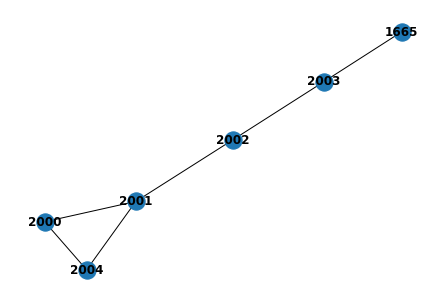

tensor([[2000, 2000, 2001, 2001, 1665, 2002],
        [2001, 2004, 2004, 2002, 2003, 2003]])
f1_score, ged 0.8333333333333334 3.0
[0.16666667 0.2        0.2        ... 0.11111111 0.14285714 0.125     ]


<Figure size 432x288 with 0 Axes>

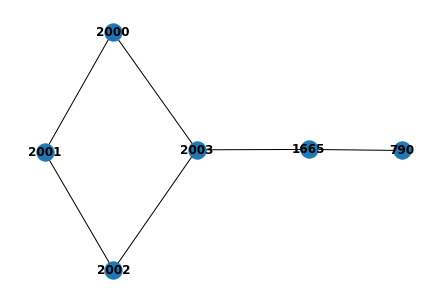

tensor([[2001, 1665, 2002, 2000, 2000,  790],
        [2002, 2003, 2003, 2003, 2001, 1665]])
f1_score, ged 0.6666666666666666 3.0
[0.2        0.25       0.25       ... 0.125      0.16666667 0.14285714]


<Figure size 432x288 with 0 Axes>

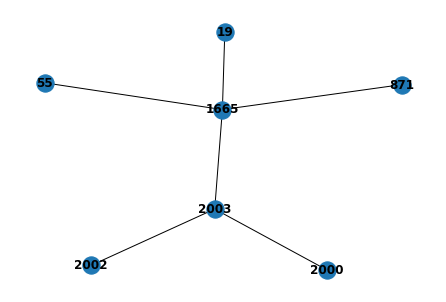

tensor([[1665, 2002, 2000,   55,   19,  871],
        [2003, 2003, 2003, 1665, 1665, 1665]])
f1_score, ged 0.3333333333333333 6.0
[0.14285714 0.16666667 0.16666667 ... 0.1        0.125      0.11111111]


<Figure size 432x288 with 0 Axes>

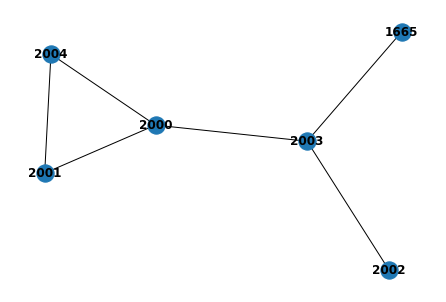

tensor([[2000, 2001, 2000, 1665, 2002, 2000],
        [2004, 2004, 2001, 2003, 2003, 2003]])
f1_score, ged 0.8333333333333334 3.0
[0.16666667 0.16666667 0.16666667 ... 0.1        0.125      0.11111111]


<Figure size 432x288 with 0 Axes>

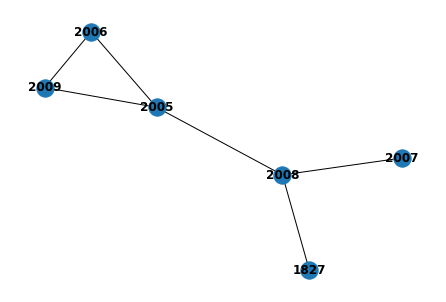

tensor([[2005, 1827, 2007, 2006, 2005, 2005],
        [2006, 2008, 2008, 2009, 2009, 2008]])
f1_score, ged 0.8333333333333334 3.0
[0.14285714 0.14285714 0.14285714 ... 0.09090909 0.11111111 0.1       ]


<Figure size 432x288 with 0 Axes>

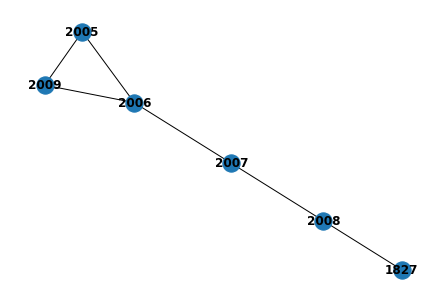

tensor([[2005, 2006, 2006, 2005, 1827, 2007],
        [2006, 2009, 2007, 2009, 2008, 2008]])
f1_score, ged 0.8333333333333334 3.0
[0.16666667 0.16666667 0.16666667 ... 0.1        0.125      0.11111111]


<Figure size 432x288 with 0 Axes>

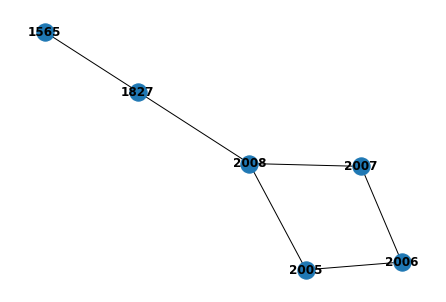

tensor([[2006, 2005, 1827, 2007, 2005, 1565],
        [2007, 2006, 2008, 2008, 2008, 1827]])
f1_score, ged 0.6666666666666666 3.0
[0.2        0.2        0.2        ... 0.11111111 0.14285714 0.125     ]


<Figure size 432x288 with 0 Axes>

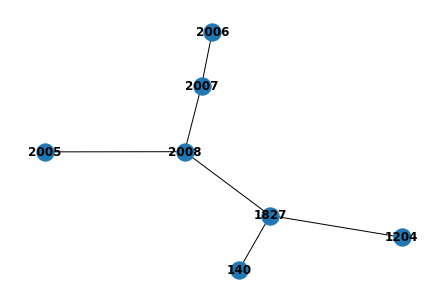

tensor([[2005, 1827, 2007,  140, 1204, 2006],
        [2008, 2008, 2008, 1827, 1827, 2007]])
f1_score, ged 0.5 6.0
[0.14285714 0.14285714 0.14285714 ... 0.09090909 0.11111111 0.1       ]


<Figure size 432x288 with 0 Axes>

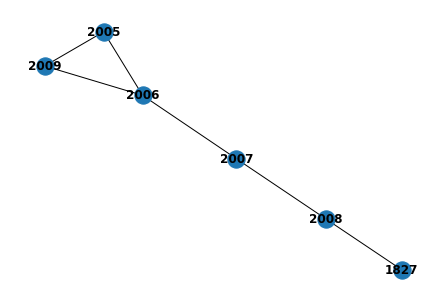

tensor([[2006, 2005, 2005, 1827, 2007, 2006],
        [2009, 2009, 2006, 2008, 2008, 2007]])
f1_score, ged 0.8333333333333334 3.0
[0.14285714 0.14285714 0.14285714 ... 0.09090909 0.11111111 0.1       ]


<Figure size 432x288 with 0 Axes>

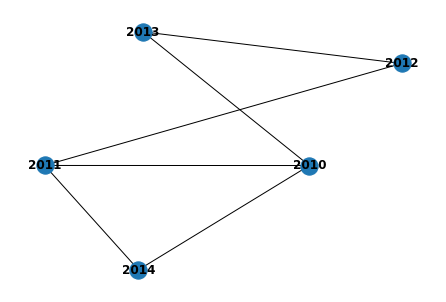

tensor([[2010, 2010, 2011, 2012, 2010, 2011],
        [2013, 2014, 2014, 2013, 2011, 2012]])
f1_score, ged 1.0 0.0
[0.16666667 0.16666667 0.16666667 ... 0.1        0.125      0.11111111]


<Figure size 432x288 with 0 Axes>

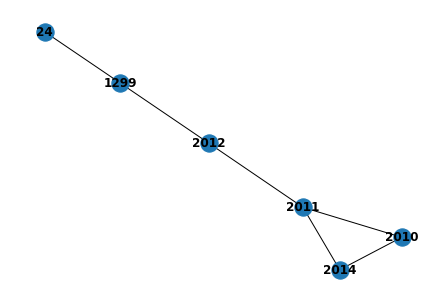

tensor([[2010, 2010, 2011, 2011, 1299,   24],
        [2011, 2014, 2012, 2014, 2012, 1299]])
f1_score, ged 0.6666666666666666 3.0
[0.2        0.2        0.2        ... 0.11111111 0.14285714 0.125     ]


<Figure size 432x288 with 0 Axes>

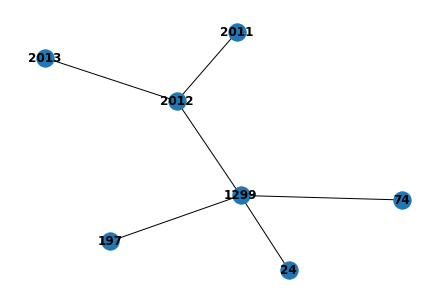

tensor([[2011, 1299,   24, 2012,  197,   74],
        [2012, 2012, 1299, 2013, 1299, 1299]])
f1_score, ged 0.3333333333333333 6.0
[0.16666667 0.16666667 0.16666667 ... 0.1        0.125      0.11111111]


<Figure size 432x288 with 0 Axes>

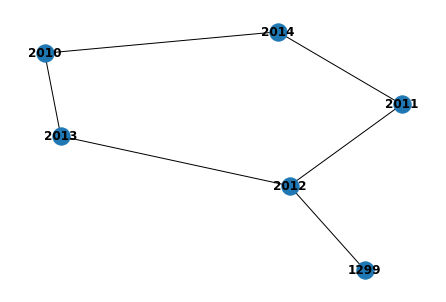

tensor([[2010, 2012, 2011, 1299, 2010, 2011],
        [2013, 2013, 2012, 2012, 2014, 2014]])
f1_score, ged 0.8333333333333334 3.0
[0.14285714 0.14285714 0.14285714 ... 0.09090909 0.11111111 0.1       ]


<Figure size 432x288 with 0 Axes>

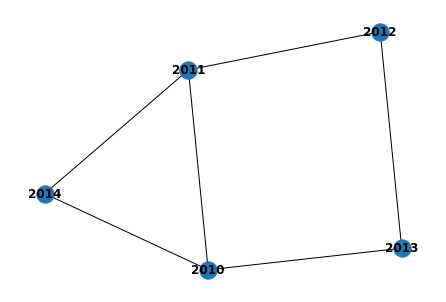

tensor([[2010, 2011, 2010, 2010, 2011, 2012],
        [2014, 2014, 2011, 2013, 2012, 2013]])
f1_score, ged 1.0 0.0
[0.16666667 0.14285714 0.14285714 ... 0.09090909 0.11111111 0.1       ]


<Figure size 432x288 with 0 Axes>

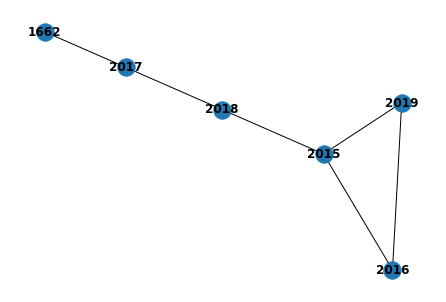

tensor([[2015, 2015, 2016, 2015, 2017, 1662],
        [2019, 2016, 2019, 2018, 2018, 2017]])
f1_score, ged 0.8333333333333334 3.0
[0.2        0.16666667 0.16666667 ... 0.1        0.125      0.11111111]


<Figure size 432x288 with 0 Axes>

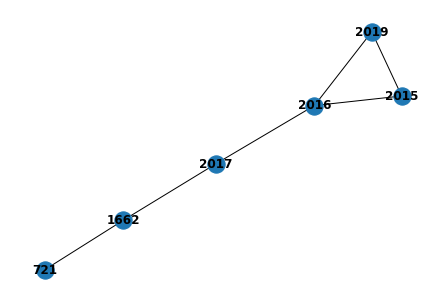

tensor([[2015, 2015, 1662, 2016, 2016,  721],
        [2016, 2019, 2017, 2017, 2019, 1662]])
f1_score, ged 0.6666666666666666 3.0
[0.25       0.2        0.2        ... 0.11111111 0.14285714 0.125     ]


<Figure size 432x288 with 0 Axes>

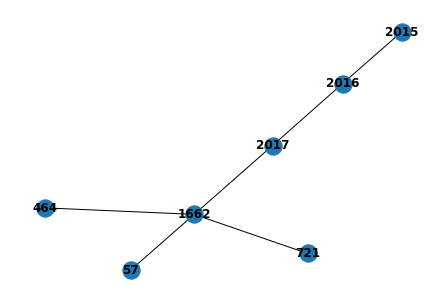

tensor([[2016, 1662,   57, 2015,  464,  721],
        [2017, 2017, 1662, 2016, 1662, 1662]])
f1_score, ged 0.3333333333333333 6.0
[0.2        0.16666667 0.16666667 ... 0.1        0.125      0.11111111]


<Figure size 432x288 with 0 Axes>

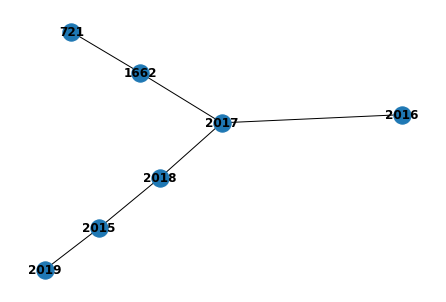

tensor([[2015, 2017, 1662, 2016, 2015,  721],
        [2018, 2018, 2017, 2017, 2019, 1662]])
f1_score, ged 0.6666666666666666 6.0
[0.16666667 0.14285714 0.14285714 ... 0.09090909 0.11111111 0.1       ]


<Figure size 432x288 with 0 Axes>

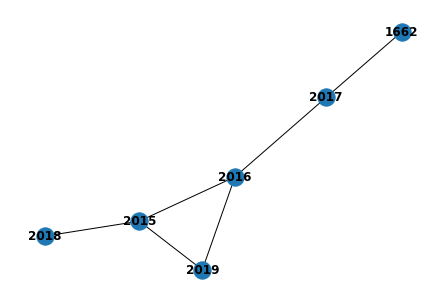

tensor([[2015, 2016, 2015, 1662, 2016, 2015],
        [2019, 2019, 2016, 2017, 2017, 2018]])
f1_score, ged 0.8333333333333334 3.0


<Figure size 432x288 with 0 Axes>

In [47]:
list_node_idx = range(n_basis,n_basis+20)#*n_shapes)
F1_scores = []
GED = []
Recall = []
Precision = []
duration_samples = []

for node_idx in list_node_idx:
    start_time = time.time()
    edge_mask = explain_distance(model, node_idx, data.x, data.edge_index, labels[node_idx])
    print(edge_mask[np.where(edge_mask>0)[0]])
    end_time = time.time()
    duration_seconds = end_time - start_time
    duration_samples.append(duration_seconds)
    
    edge_mask = mask_to_directed(edge_mask, data.edge_index)
    recall, precision, f1_score, ged = evaluate(node_idx, data, edge_mask, num_top_edges = 6)
    indices = (-edge_mask).argsort()[:6]
    print(data.edge_index[:,indices])
    
    Recall.append(recall)
    Precision.append(precision)
    F1_scores.append(f1_score)
    GED.append(ged)
    print("f1_score, ged", f1_score, ged)

In [48]:
def explain_pagerank(model, node_idx, x, edge_index, target, include_edges=None):
    data = Data(x=x, edge_index=edge_index)
    g = to_networkx(data)
    pagerank = nx.pagerank(g, personalization={node_idx: 1})

    node_attr = np.zeros(x.shape[0])
    for node, value in pagerank.items():
        node_attr[node] = value
    edge_mask = node_attr_to_edge(edge_index, node_attr)
    return edge_mask

[1.32453888e-03 1.69397530e-03 2.54784989e-03 ... 7.50785614e-06
 1.33518254e-05 9.68526597e-06]


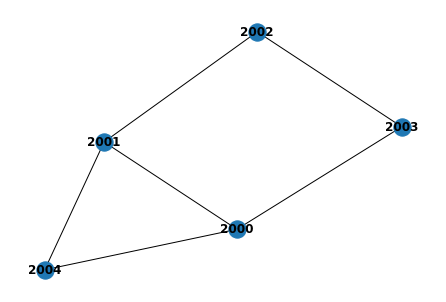

tensor([[2000, 2000, 2000, 2001, 2001, 2002],
        [2001, 2004, 2003, 2004, 2002, 2003]])
f1_score, ged 1.0 0.0
[1.11600353e-03 1.42445958e-03 2.13800134e-03 ... 6.95529024e-06
 1.20614140e-05 8.92237558e-06]


<Figure size 432x288 with 0 Axes>

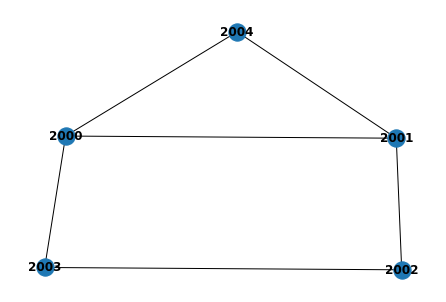

tensor([[2000, 2001, 2001, 2000, 2000, 2002],
        [2001, 2004, 2002, 2004, 2003, 2003]])
f1_score, ged 1.0 0.0
[1.53740046e-03 1.96925299e-03 2.96676362e-03 ... 8.06205697e-06
 1.46552188e-05 1.04518902e-05]


<Figure size 432x288 with 0 Axes>

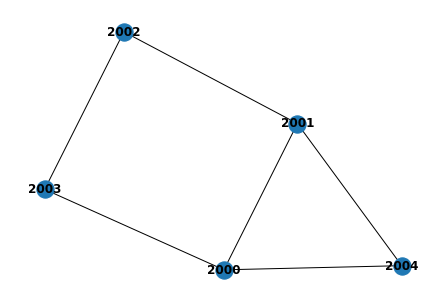

tensor([[2001, 2002, 2000, 2000, 2001, 2000],
        [2002, 2003, 2001, 2003, 2004, 2004]])
f1_score, ged 1.0 0.0
[2.48959870e-03 3.19737775e-03 4.83052295e-03 ... 1.13912594e-05
 2.15790659e-05 1.49084293e-05]


<Figure size 432x288 with 0 Axes>

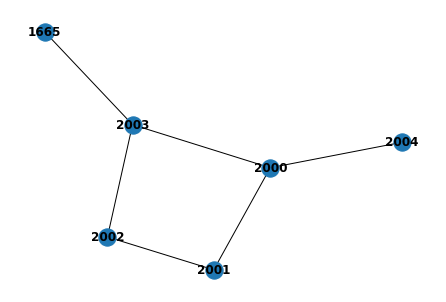

tensor([[2000, 2002, 1665, 2000, 2001, 2000],
        [2003, 2003, 2003, 2001, 2002, 2004]])
f1_score, ged 0.8333333333333334 3.0
[1.04618233e-03 1.33413151e-03 2.00045765e-03 ... 6.77583828e-06
 1.16372338e-05 8.67374532e-06]


<Figure size 432x288 with 0 Axes>

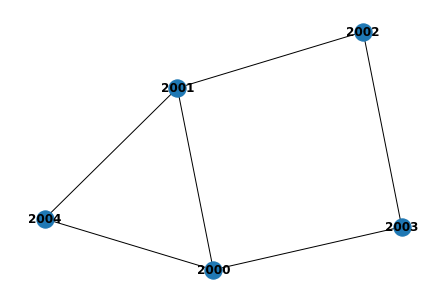

tensor([[2001, 2000, 2000, 2000, 2001, 2002],
        [2004, 2004, 2001, 2003, 2002, 2003]])
f1_score, ged 1.0 0.0
[1.10583891e-03 1.24979465e-03 1.44841009e-03 ... 7.34985856e-06
 1.29791515e-05 9.46644075e-06]


<Figure size 432x288 with 0 Axes>

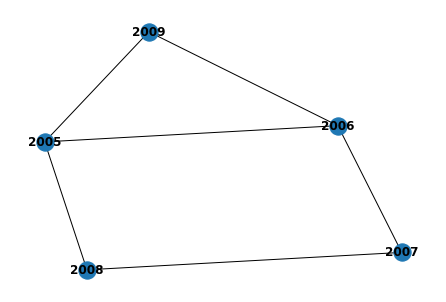

tensor([[2005, 2005, 2005, 2006, 2006, 2007],
        [2006, 2009, 2008, 2009, 2007, 2008]])
f1_score, ged 1.0 0.0
[9.25316400e-04 1.04567418e-03 1.21195350e-03 ... 6.11609110e-06
 1.08199168e-05 7.88050674e-06]


<Figure size 432x288 with 0 Axes>

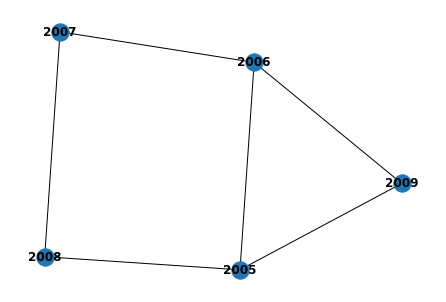

tensor([[2005, 2006, 2006, 2005, 2005, 2007],
        [2006, 2009, 2007, 2009, 2008, 2008]])
f1_score, ged 1.0 0.0
[1.28078357e-03 1.44828793e-03 1.67755761e-03 ... 7.87297539e-06
 1.42123585e-05 1.01904148e-05]


<Figure size 432x288 with 0 Axes>

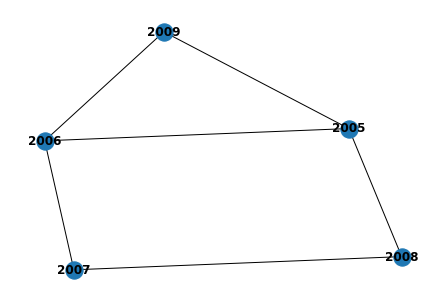

tensor([[2006, 2007, 2005, 2005, 2006, 2005],
        [2007, 2008, 2006, 2008, 2009, 2009]])
f1_score, ged 1.0 0.0
[2.06633050e-03 2.33872893e-03 2.70648849e-03 ... 1.10691951e-05
 2.08329554e-05 1.44643198e-05]


<Figure size 432x288 with 0 Axes>

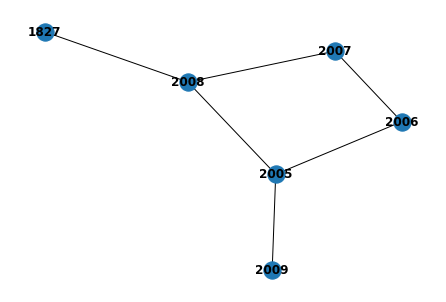

tensor([[2005, 2007, 1827, 2005, 2006, 2005],
        [2008, 2008, 2008, 2006, 2007, 2009]])
f1_score, ged 0.8333333333333334 3.0
[8.67691112e-04 9.80298783e-04 1.13647359e-03 ... 5.94188816e-06
 1.04109897e-05 7.63981236e-06]


<Figure size 432x288 with 0 Axes>

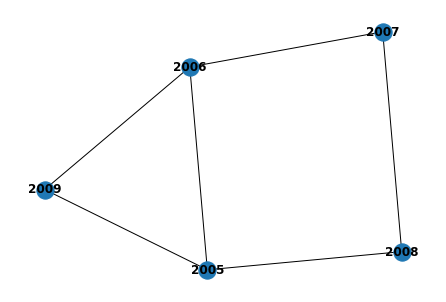

tensor([[2006, 2005, 2005, 2005, 2006, 2007],
        [2009, 2009, 2006, 2008, 2007, 2008]])
f1_score, ged 1.0 0.0
[1.65377137e-03 1.71813456e-03 1.90441342e-03 ... 6.74515672e-06
 1.15672815e-05 8.63167774e-06]


<Figure size 432x288 with 0 Axes>

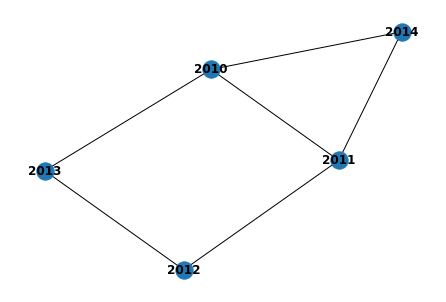

tensor([[2010, 2010, 2010, 2011, 2011, 2012],
        [2011, 2014, 2013, 2014, 2012, 2013]])
f1_score, ged 1.0 0.0
[1.97141972e-03 2.04737839e-03 2.26753949e-03 ... 7.24934231e-06
 1.27500628e-05 9.32854671e-06]


<Figure size 432x288 with 0 Axes>

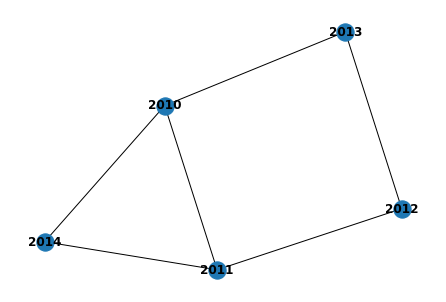

tensor([[2010, 2011, 2011, 2010, 2010, 2012],
        [2011, 2014, 2012, 2014, 2013, 2013]])
f1_score, ged 1.0 0.0
[3.73993962e-03 3.88100145e-03 4.29112664e-03 ... 1.08703802e-05
 2.03883470e-05 1.41929867e-05]


<Figure size 432x288 with 0 Axes>

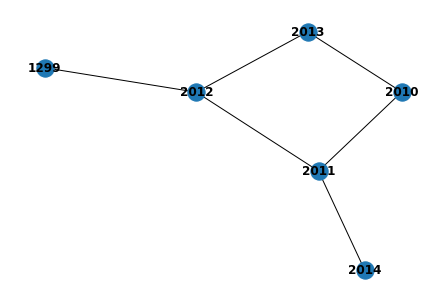

tensor([[2011, 2012, 1299, 2010, 2010, 2011],
        [2012, 2013, 2012, 2011, 2013, 2014]])
f1_score, ged 0.8333333333333334 3.0
[2.29608740e-03 2.38386118e-03 2.63856353e-03 ... 7.75403032e-06
 1.39431600e-05 1.00275987e-05]


<Figure size 432x288 with 0 Axes>

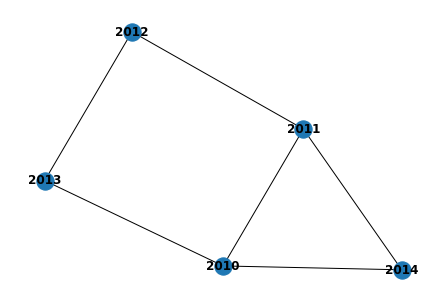

tensor([[2010, 2012, 2010, 2011, 2010, 2011],
        [2013, 2013, 2011, 2012, 2014, 2014]])
f1_score, ged 1.0 0.0
[1.54718860e-03 1.60768123e-03 1.78263570e-03 ... 6.58197222e-06
 1.11793901e-05 8.40524271e-06]


<Figure size 432x288 with 0 Axes>

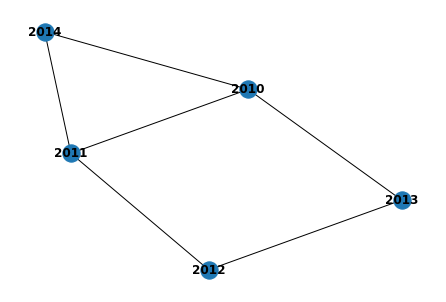

tensor([[2010, 2011, 2010, 2011, 2010, 2012],
        [2014, 2014, 2011, 2012, 2013, 2013]])
f1_score, ged 1.0 0.0
[1.06842299e-03 1.07464209e-03 1.30528532e-03 ... 7.04286122e-06
 1.22708800e-05 9.04436303e-06]


<Figure size 432x288 with 0 Axes>

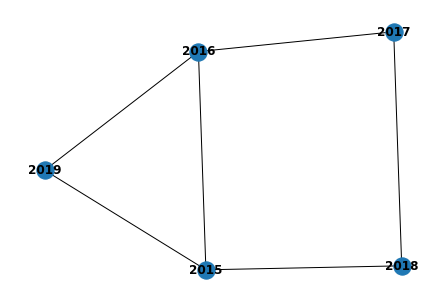

tensor([[2015, 2015, 2015, 2016, 2016, 2017],
        [2016, 2019, 2018, 2019, 2017, 2018]])
f1_score, ged 1.0 0.0
[1.26726652e-03 1.27334980e-03 1.54683762e-03 ... 7.61664186e-06
 1.36094772e-05 9.83570713e-06]


<Figure size 432x288 with 0 Axes>

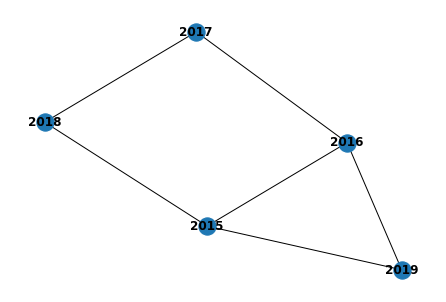

tensor([[2015, 2016, 2016, 2015, 2015, 2017],
        [2016, 2019, 2017, 2019, 2018, 2018]])
f1_score, ged 1.0 0.0
[2.37870386e-03 2.38496700e-03 2.89791356e-03 ... 1.16142031e-05
 2.20951259e-05 1.52149286e-05]


<Figure size 432x288 with 0 Axes>

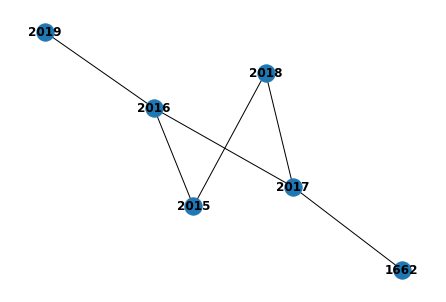

tensor([[2016, 2017, 1662, 2015, 2015, 2016],
        [2017, 2018, 2017, 2016, 2018, 2019]])
f1_score, ged 0.8333333333333334 3.0
[1.47018725e-03 1.47606849e-03 1.79326152e-03 ... 8.19252175e-06
 1.49616176e-05 1.06318333e-05]


<Figure size 432x288 with 0 Axes>

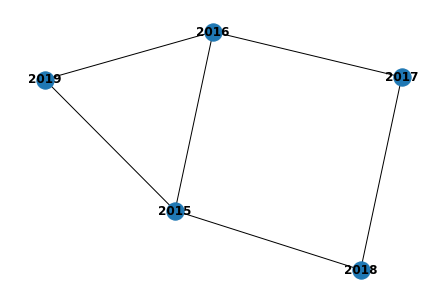

tensor([[2015, 2017, 2015, 2016, 2015, 2016],
        [2018, 2018, 2016, 2017, 2019, 2019]])
f1_score, ged 1.0 0.0
[1.00187901e-03 1.00817722e-03 1.22450018e-03 ... 6.85628102e-06
 1.18311067e-05 8.78573719e-06]


<Figure size 432x288 with 0 Axes>

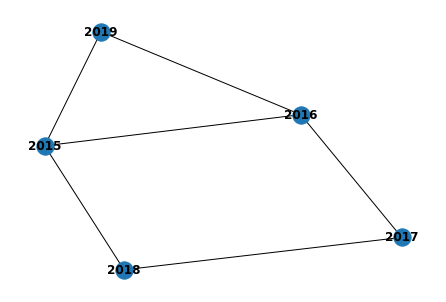

tensor([[2015, 2016, 2015, 2016, 2015, 2017],
        [2019, 2019, 2016, 2017, 2018, 2018]])
f1_score, ged 1.0 0.0


<Figure size 432x288 with 0 Axes>

In [49]:
list_node_idx = range(n_basis,n_basis+20)#*n_shapes)
F1_scores = []
GED = []
Recall = []
Precision = []
duration_samples = []

for node_idx in list_node_idx:
    start_time = time.time()
    edge_mask = explain_pagerank(model, node_idx, data.x, data.edge_index, labels[node_idx])
    print(edge_mask[np.where(edge_mask>0)[0]])
    end_time = time.time()
    duration_seconds = end_time - start_time
    duration_samples.append(duration_seconds)
    
    edge_mask = mask_to_directed(edge_mask, data.edge_index)
    recall, precision, f1_score, ged = evaluate(node_idx, data, edge_mask, num_top_edges = 6)
    indices = (-edge_mask).argsort()[:6]
    print(data.edge_index[:,indices])
    
    Recall.append(recall)
    Precision.append(precision)
    F1_scores.append(f1_score)
    GED.append(ged)
    print("f1_score, ged", f1_score, ged)

In [50]:
def get_all_convolution_layers(model):
    layers = []
    for module in model.modules():
        if isinstance(module, MessagePassing):
            layers.append(module)
    return layers

In [51]:
def explain_gradXact(model, node_idx, x, edge_index, target, include_edges=None):
    # Captum default implementation of LayerGradCam does not average over nodes for different channels because of
    # different assumptions on tensor shapes
    input_mask = x.clone().requires_grad_(True).to(device)
    layers = get_all_convolution_layers(model)
    node_attrs = []
    for layer in layers:
        layer_gc = LayerGradCam(model_forward_node, layer)
        node_attr = layer_gc.attribute(input_mask, target=target, additional_forward_args=(model, edge_index, node_idx))
        node_attr = node_attr.cpu().detach().numpy().ravel()
        node_attrs.append(node_attr)
    node_attr = np.array(node_attrs).mean(axis=0)
    edge_mask = node_attr_to_edge(edge_index, node_attr)
    return edge_mask

[0.1204521  0.1204521  0.20125673 0.1204521  0.1204521  0.1204521
 0.1204521  0.20125673]


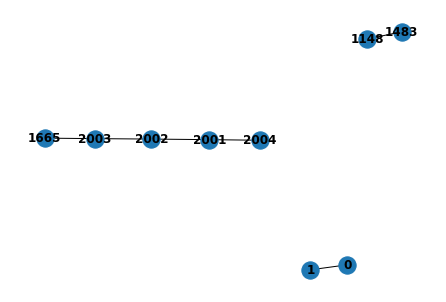

tensor([[2001, 2001, 2002, 1665,    0, 1148],
        [2004, 2002, 2003, 2003,    1, 1483]])
f1_score, ged 0.5 8.0
[0.10398949 0.17980908 0.02976248 0.02976248 0.31946054 0.10398949
 0.31946054 0.17980908]


<Figure size 432x288 with 0 Axes>

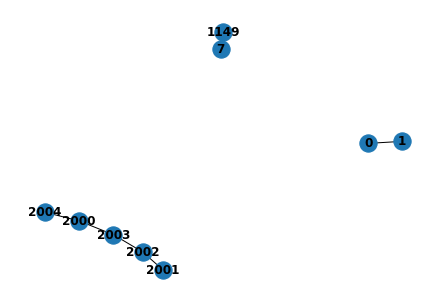

tensor([[2002, 2000, 2000, 2001,    0, 1149],
        [2003, 2004, 2003, 2002,    1,    7]])
f1_score, ged 0.6666666666666666 8.0
[0.00856322 0.00856322 0.00856322 0.00856322 0.20786595 0.00856322
 0.20786595 0.20786595 0.00856322 0.00856322 0.20786595 0.00856322]


<Figure size 432x288 with 0 Axes>

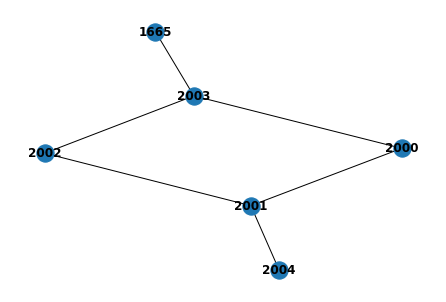

tensor([[2001, 2002, 2000, 2001, 1665, 2000],
        [2002, 2003, 2003, 2004, 2003, 2001]])
f1_score, ged 0.8333333333333334 3.0
[0.00442673 0.00442673 0.00442673 0.00442673 0.00442673 0.00442673
 0.00442673 0.00442673 0.00442673 0.00442673 0.18526092 0.00853944
 0.18937363 0.00853944 0.00853944 0.02322007 0.02322007 0.20405426
 0.18526092 0.18937363 0.20405426 0.00853944]


<Figure size 432x288 with 0 Axes>

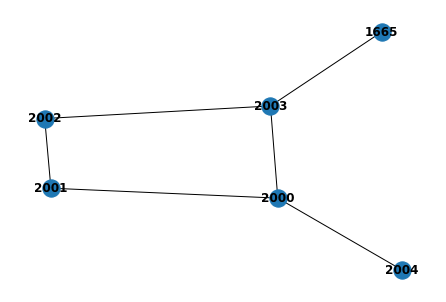

tensor([[2002, 2000, 1665, 2001, 2000, 2000],
        [2003, 2003, 2003, 2002, 2001, 2004]])
f1_score, ged 0.8333333333333334 3.0
[]


<Figure size 432x288 with 0 Axes>

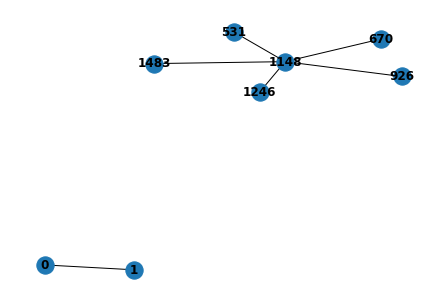

tensor([[   0, 1148, 1148, 1148, 1148, 1148],
        [   1, 1483, 1246,  926,  670,  531]])
f1_score, ged 0 9.0
[0.09791617 0.06479018 0.14708567 0.06479018 0.09791617 0.09791617
 0.09791617 0.14708567]


<Figure size 432x288 with 0 Axes>

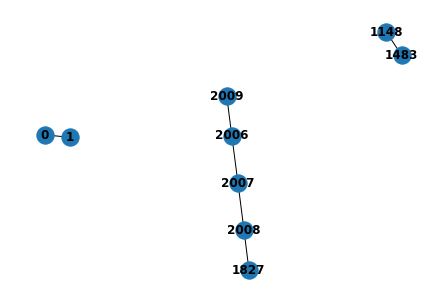

tensor([[2006, 2007, 1827, 2006,    0, 1148],
        [2009, 2008, 2008, 2007,    1, 1483]])
f1_score, ged 0.5 8.0
[0.11175023 0.1930829  0.15098821 0.11175023 0.15098821 0.1930829 ]


<Figure size 432x288 with 0 Axes>

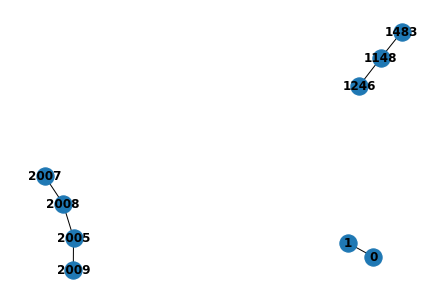

tensor([[2005, 2007, 2005,    0, 1148, 1148],
        [2009, 2008, 2008,    1, 1483, 1246]])
f1_score, ged 0.5 10.0
[0.01703784 0.01056757 0.01703784 0.01056757 0.1443434  0.01056757
 0.1443434  0.15081367 0.01703784 0.01703784 0.15081367 0.01056757]


<Figure size 432x288 with 0 Axes>

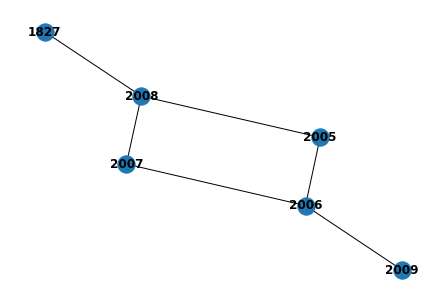

tensor([[2007, 2006, 1827, 2005, 2006, 2005],
        [2008, 2007, 2008, 2008, 2009, 2006]])
f1_score, ged 0.8333333333333334 3.0
[0.0191312  0.0191312  0.0191312  0.0191312  0.0191312  0.0191312
 0.0191312  0.0191312  0.0191312  0.0191312  0.19322271 0.00976891
 0.18386041 0.00976891 0.00976891 0.01267734 0.01267734 0.18676884
 0.19322271 0.18386041 0.18676884 0.00976891]


<Figure size 432x288 with 0 Axes>

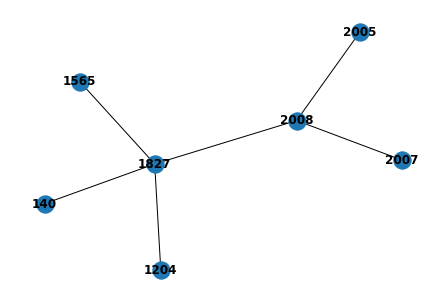

tensor([[1827, 2007, 2005, 1565,  140, 1204],
        [2008, 2008, 2008, 1827, 1827, 1827]])
f1_score, ged 0.3333333333333333 6.0
[]


<Figure size 432x288 with 0 Axes>

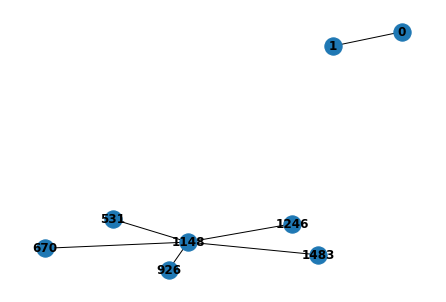

tensor([[   0, 1148, 1148, 1148, 1148, 1148],
        [   1, 1483, 1246,  926,  670,  531]])
f1_score, ged 0 9.0
[0.61410621 0.60131125 0.60131125 0.61410621 0.22178134 0.43076773
 0.22178134 0.20898639 0.60131125 0.20898639 0.60131125 0.43076773]


<Figure size 432x288 with 0 Axes>

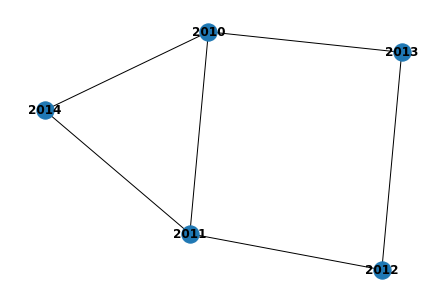

tensor([[2010, 2010, 2010, 2011, 2011, 2012],
        [2011, 2013, 2014, 2014, 2012, 2013]])
f1_score, ged 1.0 0.0
[0.20409444 0.6130867  0.21993318 0.43074322 0.6130867  0.59724796
 0.60396355 0.20409444 0.59724796 0.20409444 0.21993318 0.20409444
 0.43074322 0.60396355]


<Figure size 432x288 with 0 Axes>

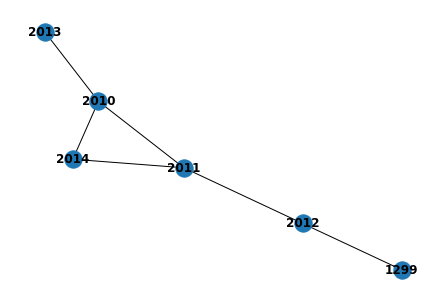

tensor([[2010, 2011, 2011, 2010, 2010, 1299],
        [2011, 2014, 2012, 2014, 2013, 2012]])
f1_score, ged 0.8333333333333334 3.0
[0.06665962 0.03173778 0.06665962 0.03173778 0.03660517 0.03660517]


<Figure size 432x288 with 0 Axes>

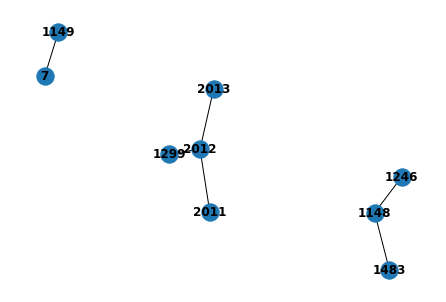

tensor([[1299, 2012, 2011, 1149, 1148, 1148],
        [2012, 2013, 2012,    7, 1483, 1246]])
f1_score, ged 0.3333333333333333 10.0
[0.0205975 0.0205975]


<Figure size 432x288 with 0 Axes>

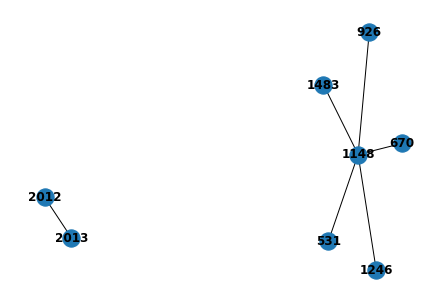

tensor([[2012, 1148, 1148, 1148, 1148, 1148],
        [2013, 1483, 1246,  926,  670,  531]])
f1_score, ged 0.16666666666666666 9.0
[]


<Figure size 432x288 with 0 Axes>

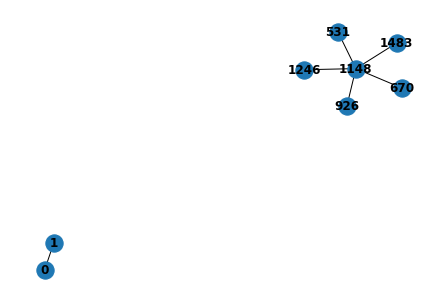

tensor([[   0, 1148, 1148, 1148, 1148, 1148],
        [   1, 1483, 1246,  926,  670,  531]])
f1_score, ged 0 9.0
[0.61410621 0.60131125 0.60131125 0.61410621 0.22178134 0.43076773
 0.22178134 0.20898639 0.60131125 0.20898639 0.60131125 0.43076773]


<Figure size 432x288 with 0 Axes>

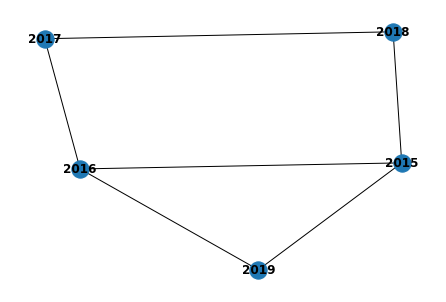

tensor([[2015, 2015, 2015, 2016, 2016, 2017],
        [2016, 2019, 2018, 2019, 2017, 2018]])
f1_score, ged 1.0 0.0
[0.20409444 0.6130867  0.21993318 0.43074322 0.6130867  0.59724796
 0.60396355 0.20409444 0.59724796 0.20409444 0.21993318 0.20409444
 0.43074322 0.60396355]


<Figure size 432x288 with 0 Axes>

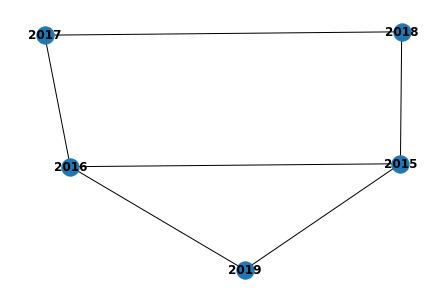

tensor([[2015, 2016, 2016, 2015, 2015, 2017],
        [2016, 2019, 2017, 2019, 2018, 2018]])
f1_score, ged 1.0 0.0
[0.06630817 0.03143407 0.06630817 0.03143407 0.03630719 0.03630719]


<Figure size 432x288 with 0 Axes>

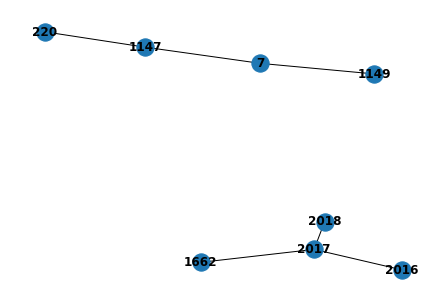

tensor([[1662, 2017, 2016, 1147, 1147, 1149],
        [2017, 2018, 2017,  220,    7,    7]])
f1_score, ged 0.3333333333333333 9.0
[0.0205975 0.0205975]


<Figure size 432x288 with 0 Axes>

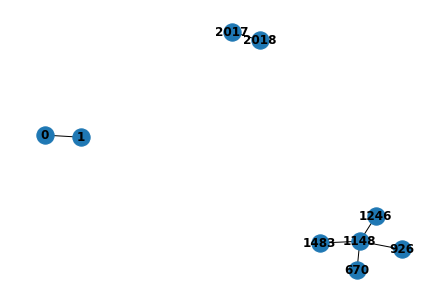

tensor([[2017,    0, 1148, 1148, 1148, 1148],
        [2018,    1, 1483, 1246,  926,  670]])
f1_score, ged 0.16666666666666666 10.0
[]


<Figure size 432x288 with 0 Axes>

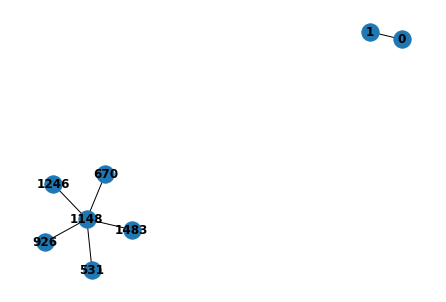

tensor([[   0, 1148, 1148, 1148, 1148, 1148],
        [   1, 1483, 1246,  926,  670,  531]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

In [52]:
list_node_idx = range(n_basis,n_basis+20)#*n_shapes)
F1_scores = []
GED = []
Recall = []
Precision = []
duration_samples = []

for node_idx in list_node_idx:
    start_time = time.time()
    edge_mask = explain_gradXact(model, node_idx, data.x, data.edge_index, labels[node_idx])
    print(edge_mask[np.where(edge_mask>0)[0]])
    end_time = time.time()
    duration_seconds = end_time - start_time
    duration_samples.append(duration_seconds)
    
    edge_mask = mask_to_directed(edge_mask, data.edge_index)
    recall, precision, f1_score, ged = evaluate(node_idx, data, edge_mask, num_top_edges = 6)
    indices = (-edge_mask).argsort()[:6]
    print(data.edge_index[:,indices])
    
    Recall.append(recall)
    Precision.append(precision)
    F1_scores.append(f1_score)
    GED.append(ged)
    print("f1_score, ged", f1_score, ged)